# Домашняя работа 5. Бустинг

*Мягкий дедлайн: 17 декабря, 21:00*

*Жесткий дедлайн: 19 декабря, 21:00*


Максимальная оценка 5 баллов :)

In [1]:
import numpy as np
import pandas as pd

from sklearn.datasets import load_boston # sorry(not sorry)
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

In [2]:
from scipy.optimize import minimize

### Задание 1. Градиентный бустинг своими руками  (2 балла)

Вам нужно реализовать упрощенный вариант градиентного бутсинга для задачи регресси. 


**Напоминание, как это работает:**

Обозначим текущую композицию на $N-1$ шаге за $a_{N - 1}(x_i)$. Базовый алгоритм $b_N(x_i)$ обучается на ответах $-\frac{\partial L(y_i, z)}{\partial z}\Bigl|_{z = a_{N - 1}(x_i)}$, где $L(y_i, z)$ — значение функции потерь на объекте при правильном ответе $y_i$ и предсказании $z$. Композиция на следующем шаге получается так:

$$
a_N(x_i) = a_{N-1}(x_i) + \nu\gamma_Nb_N(x_i)
$$

Здесь $\nu \in [0, 1]$ — темп обучения (гиперпараметр), $\gamma_N$ — оптимальный вес, настраиваемый на каждом шаге алгоритма в ходе решения оптимизационной задачи:

$$
\gamma_N = \mathrm{arg}\min_\gamma \frac{1}{\ell}\sum\limits_{i=1}^{\ell}L\left(y_i, a_{N - 1}(x_i) + \gamma b_N(x_i)\right)
$$


Заметьте, что в формуле выше нет $\nu$. Этот гиперпараметр используется для сокращения длины шага, оптимального при составлении композиции $a_N$. Идея отклонения от оптимума должна быть вам уже знакома как способ борьбы с переобучением, когда мы специально форсим модель работать чуть хуже, чем могла бы, на текущем шаге, чтобы сохранить обобщающую способность и не подогнаться под тренировочную выборку (или под шум).

С потерей в 0.5 балла можете принять $\gamma_N = 1$ для каждого $N$. На полный балл необходимо реализовать нахождение оптимального $\gamma_N$ на каждом шаге.

В качестве функции потерь $L$ возьмите MSE.

В качестве базовой модели можете использовать `DecisionTreeRegressor` из `sklearn`.
Для решения оптимизационной задачки можно воспользоваться алгоритмами из любых библиотек, например, `scipy.optimize`, или найти оптимум перебором по сетке из некоторого разумного диапазона.

Можно дописывать свои функции, если необходимо.

In [356]:
class GradientBoosting:
    def __init__(
        self, 
        base_model_class: object = DecisionTreeRegressor,
        base_model_params: dict = {'max_depth': None},
        n_estimators: int = 10,
        learning_rate: float = 0.1
    ):
        """
        
        Args:
          base_model_class: Class of the base learner.

          base_model_params: Hyperparameters of the base learner.
          
          n_estimators: Number of boosting stages.
          
          learning_rate: Value used to shrink contribution of each base learner to the model. 
          
        """
        
        self.base_model_class = base_model_class
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        
        self.base_model_params = base_model_params
        
        # list for optimal gammas at each iteration
        self.gammas = []
        
        # list for base models
        self.models = []
        
        # list for error tracking
        self.errors = []
          
    
    def find_optimal_gamma(self, 
                           y: np.array, 
                           old_predictions: np.array,
                           new_predictions: np.array) -> float:
        """You may add arguments if it's necessary for your optimization algorithm.
        
        Args:
          y: Target variable.

          old_predictions: Prediction of the additive model at the previous stage.
          
          new_predictions: Prediction of the base learner at the current stage. 
          
        Returns:
          Optimal value for gamma.
          
        """
        optimal_gamma = minimize(lambda gamma: np.sum((y - old_predictions - gamma*new_predictions)**2), x0 = 1).x[0]
        self.gammas.append(optimal_gamma)
    
    
    def _fit_base_model(self, X: np.ndarray, y: np.array):
        """Train one base learner. 
        
        Args:
          X: Feature matrix
          
          y: Target variable.
          
          
        Returns:
          Fitted base learner.
          
        """
        base_model = DecisionTreeRegressor()
        base_model.set_params(**self.base_model_params)
        base_model.fit(X, y)
        self.models.append(base_model)
        return base_model
    
        
    def fit(self, X: np.ndarray, y: np.array):
        """Train boosting ("sum" of base learners). 
        
        Args:
          X: Feature matrix
          
          y: Target variable.
          
          
        Returns:
          Fitted boosting.
          
        """
        
        for i in range(self.n_estimators):
            if len(self.models) == 0:
                    self.models.append(np.zeros(X.shape[0]))
                    self.gammas.append(1)
            else:
                s = 2*(y-self.predict(X))/len(X)
                old_predictions = self.predict(X)
                model = self._fit_base_model(X, s)
                
                self.find_optimal_gamma(y, old_predictions, model.predict(X))
            if i % 2 == 0:
                self.errors.append(mean_squared_error(y, self.predict(X)))
        return self
       
        
    def predict(self, X: np.ndarray):
        """Make prediction of fitted boosting. 
        
        Args:
          X: Feature matrix


        Returns:
          Prediction of fitted boosting.
          
        """
        if len(self.models) > 0:
            y_predicted = np.zeros(X.shape[0])
            for i, base_model in enumerate(self.models[1:]):
                y_predicted += self.learning_rate*self.gammas[i]*base_model.predict(X)
            return y_predicted
            

Проверьте вашу реализацию на бостонском датасете. Подберите оптимальные гиперпараметры, чтобы победить RandomForestRegressor (не меняйте параметры сида).

In [201]:
boston = load_boston()
X = boston.data
y = boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

In [202]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_features=4, n_estimators=640, random_state=19052019)

rf.fit(X_train, y_train)
mean_squared_error(y_test, rf.predict(X_test))

9.63198271791959

Попробуем запустить `Gradient Boosting` с дефолтными параметрами. Зафисксируем случайный seed для воспроизводимости результатов.

In [315]:
%%time

gb = GradientBoosting(base_model_params={"random_state" : 42})
gb.fit(X_train, y_train)
print(f"MSE of this model is {mean_squared_error(y_test, gb.predict(X_test))}")

MSE of this model is 121.41628142959033
Wall time: 61.9 ms


Видно, что разница очень велика. Попробуем подобрать по сетке гиперпараметры:

In [347]:
%%time
params = {
    "n_estimators" : np.arange(10, 60, 2),
    "learning_rate" : np.arange(0.1, 0.25, 0.025),
    "max_depth" : np.arange(1, 7),
    "min_samples_leaf" : np.arange(2, 5),
    "max_features" : np.arange(1, 5)
}
keys = list(params.keys())
combinations = np.array(np.meshgrid(*list(params.values()))).T.reshape(-1,5)
best_MSE = None
best_params = None
for i in combinations:
    base_model_params = dict(zip(keys[2:], i[2:].astype(int)))
    base_model_params["random_state"] = 42
    gb = GradientBoosting(n_estimators=int(i[0]), learning_rate=i[1], base_model_params=base_model_params)
    gb.fit(X_train, y_train)
    mse = mean_squared_error(y_test, gb.predict(X_test))
    if best_MSE is None:
        best_MSE = mse
        best_params = i
    if mse < best_MSE:
        best_MSE = mse
        best_params = i

Wall time: 41min 39s


Параметры и скор лучшей модели:

In [353]:
print("Parameters of the best model:")
for i, key in enumerate(keys):
    print(f"\t{key} : {best_params[i]}")
print(f"MSE of the best model is {best_MSE}")

Parameters of the best model:
	n_estimators : 58.0
	learning_rate : 0.15
	max_depth : 6.0
	min_samples_leaf : 4.0
	max_features : 4.0
MSE of the best model is 8.815345865232844


В итоге, я подобрал гиперпараметры, которые победили RandomForest, хотя и кажется, что здесь randomforest лучше справляется. При переборе гиперпараметров можно было еще сделать early stopping, но я слишком поздно это понял и мне лень еще раз запускать это.

In [359]:
# best model once again
gb = GradientBoosting(n_estimators=58, learning_rate=0.15, base_model_params={'max_depth':6, "min_samples_leaf":4, "max_features":4, "random_state":42})
gb.fit(X_train, y_train)
mean_squared_error(y_test, gb.predict(X_test))

8.815345865232844

Text(0.5, 1.0, 'Best model train')

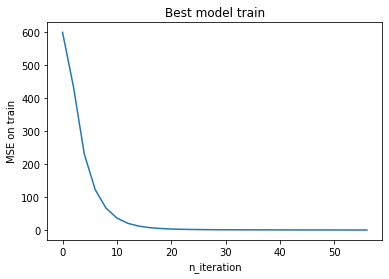

In [365]:
from matplotlib import pyplot as plt
plt.plot(np.arange(len(gb.errors))*2, gb.errors)
plt.xlabel("n_iteration")
plt.ylabel('MSE on train')
plt.title("Best model train")

### Задание 2. Сравнение подходов (1.5 балла)

Скачайте данные о выдаче кредитов. Это данные с kaggle, целевая переменная `y` показывает, вернуло ли кредит физическое лицо.

In [403]:
!wget  -O 'bank_data.csv' -q 'https://www.dropbox.com/s/uy27mctxo0gbuof/bank_data.csv?dl=0'

In [487]:
df = pd.read_csv('bank_data.csv')
df.sample(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
7788,58,admin.,married,basic.4y,unknown,no,yes,telephone,may,wed,...,2,999,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0,-1
6856,45,admin.,married,high.school,no,yes,no,cellular,oct,fri,...,3,6,1,success,-1.1,94.601,-49.5,1.029,4963.6,1
5112,39,technician,divorced,university.degree,no,no,no,cellular,jul,mon,...,2,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,-1
2944,43,management,married,university.degree,no,no,no,telephone,jun,fri,...,5,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,-1
6836,27,admin.,single,high.school,unknown,yes,no,cellular,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.958,5228.1,-1


In [488]:
y = df.y
df = df.drop(columns=["y"])

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.25, shuffle=True, random_state=13)
categorical_features = [1,2,3,4,5,6,7,8,9,14]
numeric_features = list(set(np.arange(19)) - set(categorical_features))

In [489]:
X_train.iloc[:, categorical_features]

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome
8024,admin.,divorced,high.school,no,yes,no,cellular,jul,fri,nonexistent
6414,retired,divorced,professional.course,no,yes,no,telephone,sep,wed,nonexistent
5038,technician,single,high.school,no,no,no,cellular,aug,mon,nonexistent
4764,admin.,single,high.school,no,yes,no,cellular,oct,fri,success
2192,technician,single,professional.course,no,yes,no,cellular,aug,thu,nonexistent
...,...,...,...,...,...,...,...,...,...,...
5876,technician,single,professional.course,no,no,yes,cellular,jul,tue,nonexistent
866,management,married,high.school,no,no,no,cellular,nov,thu,nonexistent
7696,housemaid,single,university.degree,no,no,no,cellular,may,fri,nonexistent
74,admin.,married,university.degree,no,yes,no,cellular,jul,fri,success


In [490]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
preprocessor = ColumnTransformer(transformers=[
    ("num", StandardScaler(), numeric_features),
    ("cat", OneHotEncoder(handle_unknown = 'ignore'), categorical_features)])

Решите задачу предсказания возвращения кредита методами, перечисленными ниже:

- Случайный лес
- Бэггинг на деревьях (поставьте для базовых деревьев min_samples_leaf=1)
- Бэггинг, у которого базовой моделью является бустинг с большим числом деревьев (> 100)
- Бэггинг на логистических регрессиях

Используйте логистическую регрессию, случайный лес, `GradientBoostingClassifier` и `BaggingClassifier` из `sklearn`.

1) Какая из моделей имеет лучшее качество? С чем это связано?

2) Какая из моделей сильнее всего переобучается?


In [491]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score

In [492]:
np.random.seed(42)

In [493]:
%%time

pipeline = Pipeline([("preprocessor", preprocessor), ('rfc', RandomForestClassifier())])
pipeline.fit(X_train, y_train)
print(f"ROC-AUC score on test is {roc_auc_score(y_train, pipeline.predict_proba(X_train)[:, 1])}")
print(f"ROC-AUC score on test is {roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1])}")

ROC-AUC score on test is 1.0
ROC-AUC score on test is 0.938849883578814
Wall time: 1.01 s


In [494]:
%%time

pipeline = Pipeline([("preprocessor", preprocessor), ('bc_tree', BaggingClassifier(DecisionTreeClassifier()))])
pipeline.fit(X_train, y_train)
print(f"ROC-AUC score on test is {roc_auc_score(y_train, pipeline.predict_proba(X_train)[:, 1])}")
print(f"ROC-AUC score on test is {roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1])}")

ROC-AUC score on test is 0.9997506175930535
ROC-AUC score on test is 0.9321337341909545
Wall time: 497 ms


In [495]:
%%time

pipeline = Pipeline([("preprocessor", preprocessor), ('bc_boosting', BaggingClassifier(GradientBoostingClassifier(n_estimators=200)))])
pipeline.fit(X_train, y_train)
print(f"ROC-AUC score on test is {roc_auc_score(y_train, pipeline.predict_proba(X_train)[:, 1])}")
print(f"ROC-AUC score on test is {roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1])}")

ROC-AUC score on test is 0.9731323487297516
ROC-AUC score on test is 0.9433981901932622
Wall time: 20.4 s


In [496]:
%%time

pipeline = Pipeline([("preprocessor", preprocessor), ('bc_logreg', BaggingClassifier(LogisticRegression(max_iter=200)))])
pipeline.fit(X_train, y_train)
print(f"ROC-AUC score on test is {roc_auc_score(y_train, pipeline.predict_proba(X_train)[:, 1])}")
print(f"ROC-AUC score on test is {roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1])}")

ROC-AUC score on test is 0.9439655072751949
ROC-AUC score on test is 0.9343023203946723
Wall time: 1.08 s


    1) У меня получилось, что лучше всего работает бэггинг на градиентном бустинге. Я думаю, что это связано с тем, что градиентный бустинг сам по себе очень сильный алгоритм, а бэггинг только улучшает его, делая более стабильным и уменьшая дисперсию ошибки. Также он не так сильно переобучился как random forest. Кстати, второй по качеству алгоритм - RandomForest, который тоже довольно сильная модель, так как это ансамбль.
    2) Сильнее всего переобучается random forest

### Задание 3. Современные бустинги (1.5 балла)

Сравните на этих данных любую из трёх популярных имплементаций градиентного бустинга (xgboost, lightgbm, catboost). Подберите основные гиперпараметры (число деревьев, длина шага, глубина дерева/число листьев). Получилось ли круче, чем с моделями выше?

Я буду использовать `catboost`.

In [497]:
from catboost import CatBoostClassifier

In [514]:
%%time

# base model
CatBoost_model = CatBoostClassifier(
    iterations=100,
    task_type="GPU",
    eval_metric="AUC"
)
CatBoost_model.fit(
    X_train, y_train,
    cat_features=categorical_features,
    verbose=0
)
print(f"ROC-AUC score on test is {roc_auc_score(y_train, CatBoost_model.predict_proba(X_train)[:, 1])}")
print(f"ROC-AUC score on test is {roc_auc_score(y_test, CatBoost_model.predict_proba(X_test)[:, 1])}")

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

ROC-AUC score on test is 0.9801901185772057
ROC-AUC score on test is 0.9417552092161567
Wall time: 2.19 s


In [516]:
CatBoost_model = CatBoostClassifier(
    task_type="GPU",
    eval_metric="AUC",
    cat_features=categorical_features,
)
grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 4, 9],
        'iterations': [100,200]
}

grid_search_result = CatBoost_model.grid_search(grid,
                                                X=X_train, 
                                                y=y_train,
                                                verbose=0,
                                                plot=True)


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.9172362	test: 0.9101355	best: 0.9101355 (0)	total: 28.1ms	remaining: 2.78s
1:	learn: 0.9224162	test: 0.9171565	best: 0.9171565 (1)	total: 55.2ms	remaining: 2.71s
2:	learn: 0.9252358	test: 0.9217215	best: 0.9217215 (2)	total: 82ms	remaining: 2.65s
3:	learn: 0.9306263	test: 0.9270938	best: 0.9270938 (3)	total: 109ms	remaining: 2.61s
4:	learn: 0.9304117	test: 0.9260698	best: 0.9270938 (3)	total: 137ms	remaining: 2.6s
5:	learn: 0.9317754	test: 0.9273602	best: 0.9273602 (5)	total: 165ms	remaining: 2.58s
6:	learn: 0.9347798	test: 0.9298306	best: 0.9298306 (6)	total: 192ms	remaining: 2.55s
7:	learn: 0.9355240	test: 0.9301196	best: 0.9301196 (7)	total: 220ms	remaining: 2.52s
8:	learn: 0.9351070	test: 0.9290894	best: 0.9301196 (7)	total: 252ms	remaining: 2.54s
9:	learn: 0.9348545	test: 0.9287817	best: 0.9301196 (7)	total: 283ms	remaining: 2.54s
10:	learn: 0.9353698	test: 0.9291441	best: 0.9301196 (7)	total: 309ms	remaining: 2.5s
11:	learn: 0.9359822	test: 0.9293495	best: 0.9301196 (

94:	learn: 0.9517709	test: 0.9398443	best: 0.9398443 (94)	total: 2.75s	remaining: 145ms
95:	learn: 0.9519508	test: 0.9400756	best: 0.9400756 (95)	total: 2.78s	remaining: 116ms
96:	learn: 0.9519701	test: 0.9400983	best: 0.9400983 (96)	total: 2.81s	remaining: 86.8ms
97:	learn: 0.9520816	test: 0.9401499	best: 0.9401499 (97)	total: 2.83s	remaining: 57.8ms
98:	learn: 0.9522108	test: 0.9402738	best: 0.9402738 (98)	total: 2.86s	remaining: 28.9ms
99:	learn: 0.9523095	test: 0.9403378	best: 0.9403378 (99)	total: 2.89s	remaining: 0us
bestTest = 0.9403377771
bestIteration = 99
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	learn: 0.9172362	test: 0.9101355	best: 0.9101355 (0)	total: 23.9ms	remaining: 2.37s
1:	learn: 0.9231437	test: 0.9171194	best: 0.9171194 (1)	total: 48.7ms	remaining: 2.38s
2:	learn: 0.9292206	test: 0.9235281	best: 0.9235281 (2)	total: 74ms	remaining: 2.39s
3:	learn: 0.9348500	test: 0.9283007

86:	learn: 0.9591517	test: 0.9431643	best: 0.9431643 (86)	total: 2.47s	remaining: 369ms
87:	learn: 0.9592069	test: 0.9431354	best: 0.9431643 (86)	total: 2.5s	remaining: 340ms
88:	learn: 0.9593055	test: 0.9431292	best: 0.9431643 (86)	total: 2.52s	remaining: 312ms
89:	learn: 0.9593936	test: 0.9431664	best: 0.9431664 (89)	total: 2.55s	remaining: 283ms
90:	learn: 0.9594135	test: 0.9431623	best: 0.9431664 (89)	total: 2.57s	remaining: 255ms
91:	learn: 0.9594203	test: 0.9431871	best: 0.9431871 (91)	total: 2.6s	remaining: 226ms
92:	learn: 0.9594928	test: 0.9431994	best: 0.9431994 (92)	total: 2.63s	remaining: 198ms
93:	learn: 0.9595245	test: 0.9431994	best: 0.9431994 (92)	total: 2.65s	remaining: 169ms
94:	learn: 0.9596252	test: 0.9431499	best: 0.9431994 (92)	total: 2.68s	remaining: 141ms
95:	learn: 0.9596467	test: 0.9431912	best: 0.9431994 (92)	total: 2.71s	remaining: 113ms
96:	learn: 0.9597185	test: 0.9432820	best: 0.9432820 (96)	total: 2.74s	remaining: 84.8ms
97:	learn: 0.9598486	test: 0.9433

80:	learn: 0.9501295	test: 0.9375184	best: 0.9377229 (75)	total: 2.22s	remaining: 522ms
81:	learn: 0.9501535	test: 0.9375019	best: 0.9377229 (75)	total: 2.25s	remaining: 494ms
82:	learn: 0.9502439	test: 0.9377745	best: 0.9377745 (82)	total: 2.28s	remaining: 466ms
83:	learn: 0.9503933	test: 0.9377951	best: 0.9377951 (83)	total: 2.3s	remaining: 439ms
84:	learn: 0.9506209	test: 0.9380171	best: 0.9380171 (84)	total: 2.33s	remaining: 411ms
85:	learn: 0.9506560	test: 0.9380821	best: 0.9380821 (85)	total: 2.35s	remaining: 383ms
86:	learn: 0.9507111	test: 0.9380532	best: 0.9380821 (85)	total: 2.38s	remaining: 356ms
87:	learn: 0.9507624	test: 0.9382731	best: 0.9382731 (87)	total: 2.41s	remaining: 329ms
88:	learn: 0.9508817	test: 0.9383825	best: 0.9383825 (88)	total: 2.44s	remaining: 302ms
89:	learn: 0.9509149	test: 0.9382463	best: 0.9383825 (88)	total: 2.47s	remaining: 275ms
90:	learn: 0.9510446	test: 0.9384806	best: 0.9384806 (90)	total: 2.5s	remaining: 247ms
91:	learn: 0.9511003	test: 0.93850

73:	learn: 0.9578658	test: 0.9433409	best: 0.9433409 (73)	total: 2.01s	remaining: 707ms
74:	learn: 0.9578741	test: 0.9432954	best: 0.9433409 (73)	total: 2.04s	remaining: 680ms
75:	learn: 0.9581964	test: 0.9433161	best: 0.9433409 (73)	total: 2.06s	remaining: 652ms
76:	learn: 0.9581820	test: 0.9432913	best: 0.9433409 (73)	total: 2.09s	remaining: 625ms
77:	learn: 0.9582447	test: 0.9433997	best: 0.9433997 (77)	total: 2.12s	remaining: 598ms
78:	learn: 0.9583874	test: 0.9433853	best: 0.9433997 (77)	total: 2.15s	remaining: 570ms
79:	learn: 0.9584600	test: 0.9433883	best: 0.9433997 (77)	total: 2.17s	remaining: 543ms
80:	learn: 0.9585822	test: 0.9432975	best: 0.9433997 (77)	total: 2.2s	remaining: 517ms
81:	learn: 0.9587047	test: 0.9434937	best: 0.9434937 (81)	total: 2.23s	remaining: 490ms
82:	learn: 0.9587559	test: 0.9433718	best: 0.9434937 (81)	total: 2.26s	remaining: 463ms
83:	learn: 0.9587699	test: 0.9433739	best: 0.9434937 (81)	total: 2.28s	remaining: 435ms
84:	learn: 0.9589095	test: 0.9433

72:	learn: 0.9492456	test: 0.9374173	best: 0.9374173 (72)	total: 1.96s	remaining: 726ms
73:	learn: 0.9492785	test: 0.9373966	best: 0.9374173 (72)	total: 1.99s	remaining: 698ms
74:	learn: 0.9495233	test: 0.9375474	best: 0.9375474 (74)	total: 2.01s	remaining: 671ms
75:	learn: 0.9497378	test: 0.9375019	best: 0.9375474 (74)	total: 2.04s	remaining: 644ms
76:	learn: 0.9497968	test: 0.9376176	best: 0.9376176 (76)	total: 2.07s	remaining: 618ms
77:	learn: 0.9498585	test: 0.9375948	best: 0.9376176 (76)	total: 2.1s	remaining: 592ms
78:	learn: 0.9498808	test: 0.9376010	best: 0.9376176 (76)	total: 2.13s	remaining: 566ms
79:	learn: 0.9499024	test: 0.9375783	best: 0.9376176 (76)	total: 2.16s	remaining: 540ms
80:	learn: 0.9498852	test: 0.9375122	best: 0.9376176 (76)	total: 2.19s	remaining: 513ms
81:	learn: 0.9498982	test: 0.9375184	best: 0.9376176 (76)	total: 2.21s	remaining: 486ms
82:	learn: 0.9500239	test: 0.9377662	best: 0.9377662 (82)	total: 2.24s	remaining: 459ms
83:	learn: 0.9500936	test: 0.9377

65:	learn: 0.9562778	test: 0.9423643	best: 0.9423746 (64)	total: 1.77s	remaining: 914ms
66:	learn: 0.9564463	test: 0.9424944	best: 0.9424944 (66)	total: 1.8s	remaining: 889ms
67:	learn: 0.9565606	test: 0.9423828	best: 0.9424944 (66)	total: 1.83s	remaining: 861ms
68:	learn: 0.9567121	test: 0.9424685	best: 0.9424944 (66)	total: 1.86s	remaining: 835ms
69:	learn: 0.9569220	test: 0.9425986	best: 0.9425986 (69)	total: 1.88s	remaining: 808ms
70:	learn: 0.9570216	test: 0.9427390	best: 0.9427390 (70)	total: 1.91s	remaining: 781ms
71:	learn: 0.9570406	test: 0.9425924	best: 0.9427390 (70)	total: 1.94s	remaining: 755ms
72:	learn: 0.9572163	test: 0.9425697	best: 0.9427390 (70)	total: 1.97s	remaining: 727ms
73:	learn: 0.9574299	test: 0.9426667	best: 0.9427390 (70)	total: 2s	remaining: 702ms
74:	learn: 0.9574358	test: 0.9426492	best: 0.9427390 (70)	total: 2.02s	remaining: 674ms
75:	learn: 0.9575001	test: 0.9427648	best: 0.9427648 (75)	total: 2.05s	remaining: 647ms
76:	learn: 0.9576666	test: 0.9428412

57:	learn: 0.9492096	test: 0.9380264	best: 0.9380697 (56)	total: 2.27s	remaining: 5.56s
58:	learn: 0.9493999	test: 0.9379696	best: 0.9380697 (56)	total: 2.31s	remaining: 5.51s
59:	learn: 0.9494079	test: 0.9379345	best: 0.9380697 (56)	total: 2.34s	remaining: 5.47s
60:	learn: 0.9493841	test: 0.9380522	best: 0.9380697 (56)	total: 2.38s	remaining: 5.43s
61:	learn: 0.9495589	test: 0.9382452	best: 0.9382452 (61)	total: 2.42s	remaining: 5.39s
62:	learn: 0.9496286	test: 0.9383422	best: 0.9383422 (62)	total: 2.46s	remaining: 5.34s
63:	learn: 0.9497910	test: 0.9384538	best: 0.9384538 (63)	total: 2.49s	remaining: 5.3s
64:	learn: 0.9498681	test: 0.9385157	best: 0.9385157 (64)	total: 2.53s	remaining: 5.25s
65:	learn: 0.9500094	test: 0.9386540	best: 0.9386540 (65)	total: 2.57s	remaining: 5.21s
66:	learn: 0.9500637	test: 0.9386623	best: 0.9386623 (66)	total: 2.6s	remaining: 5.17s
67:	learn: 0.9500565	test: 0.9387831	best: 0.9387831 (67)	total: 2.64s	remaining: 5.13s
68:	learn: 0.9501791	test: 0.93890

152:	learn: 0.9557602	test: 0.9421020	best: 0.9421020 (151)	total: 5.94s	remaining: 1.82s
153:	learn: 0.9557693	test: 0.9420236	best: 0.9421020 (151)	total: 5.98s	remaining: 1.78s
154:	learn: 0.9557825	test: 0.9420442	best: 0.9421020 (151)	total: 6.01s	remaining: 1.75s
155:	learn: 0.9558145	test: 0.9420525	best: 0.9421020 (151)	total: 6.05s	remaining: 1.71s
156:	learn: 0.9558819	test: 0.9420546	best: 0.9421020 (151)	total: 6.09s	remaining: 1.67s
157:	learn: 0.9559934	test: 0.9420773	best: 0.9421020 (151)	total: 6.13s	remaining: 1.63s
158:	learn: 0.9560153	test: 0.9420628	best: 0.9421020 (151)	total: 6.17s	remaining: 1.59s
159:	learn: 0.9560669	test: 0.9421485	best: 0.9421485 (159)	total: 6.21s	remaining: 1.55s
160:	learn: 0.9560876	test: 0.9421403	best: 0.9421485 (159)	total: 6.25s	remaining: 1.51s
161:	learn: 0.9561718	test: 0.9421423	best: 0.9421485 (159)	total: 6.3s	remaining: 1.48s
162:	learn: 0.9562025	test: 0.9422001	best: 0.9422001 (162)	total: 6.33s	remaining: 1.44s
163:	learn:

43:	learn: 0.9548188	test: 0.9413402	best: 0.9413619 (42)	total: 1.65s	remaining: 5.85s
44:	learn: 0.9549162	test: 0.9411244	best: 0.9413619 (42)	total: 1.69s	remaining: 5.83s
45:	learn: 0.9550935	test: 0.9413268	best: 0.9413619 (42)	total: 1.74s	remaining: 5.82s
46:	learn: 0.9553311	test: 0.9414527	best: 0.9414527 (46)	total: 1.78s	remaining: 5.79s
47:	learn: 0.9553381	test: 0.9414837	best: 0.9414837 (47)	total: 1.82s	remaining: 5.76s
48:	learn: 0.9553892	test: 0.9415931	best: 0.9415931 (48)	total: 1.85s	remaining: 5.71s
49:	learn: 0.9556760	test: 0.9417934	best: 0.9417934 (49)	total: 1.89s	remaining: 5.67s
50:	learn: 0.9560283	test: 0.9420184	best: 0.9420184 (50)	total: 1.92s	remaining: 5.62s
51:	learn: 0.9561920	test: 0.9420948	best: 0.9420948 (51)	total: 1.96s	remaining: 5.58s
52:	learn: 0.9563047	test: 0.9421712	best: 0.9421712 (52)	total: 1.99s	remaining: 5.53s
53:	learn: 0.9563073	test: 0.9420938	best: 0.9421712 (52)	total: 2.03s	remaining: 5.49s
54:	learn: 0.9565160	test: 0.941

141:	learn: 0.9626206	test: 0.9442225	best: 0.9442266 (139)	total: 5.36s	remaining: 2.19s
142:	learn: 0.9626244	test: 0.9442060	best: 0.9442266 (139)	total: 5.4s	remaining: 2.15s
143:	learn: 0.9627442	test: 0.9442865	best: 0.9442865 (143)	total: 5.44s	remaining: 2.11s
144:	learn: 0.9627776	test: 0.9442824	best: 0.9442865 (143)	total: 5.48s	remaining: 2.08s
145:	learn: 0.9628602	test: 0.9442617	best: 0.9442865 (143)	total: 5.51s	remaining: 2.04s
146:	learn: 0.9628810	test: 0.9442638	best: 0.9442865 (143)	total: 5.55s	remaining: 2s
147:	learn: 0.9628915	test: 0.9442720	best: 0.9442865 (143)	total: 5.6s	remaining: 1.97s
148:	learn: 0.9629279	test: 0.9443071	best: 0.9443071 (148)	total: 5.64s	remaining: 1.93s
149:	learn: 0.9629802	test: 0.9442824	best: 0.9443071 (148)	total: 5.67s	remaining: 1.89s
150:	learn: 0.9629959	test: 0.9442824	best: 0.9443071 (148)	total: 5.71s	remaining: 1.85s
151:	learn: 0.9629946	test: 0.9442700	best: 0.9443071 (148)	total: 5.74s	remaining: 1.81s
152:	learn: 0.9

37:	learn: 0.9441701	test: 0.9349954	best: 0.9350119 (34)	total: 1.38s	remaining: 5.9s
38:	learn: 0.9446597	test: 0.9351275	best: 0.9351275 (38)	total: 1.42s	remaining: 5.88s
39:	learn: 0.9448386	test: 0.9353051	best: 0.9353051 (39)	total: 1.47s	remaining: 5.86s
40:	learn: 0.9450431	test: 0.9354610	best: 0.9354610 (40)	total: 1.5s	remaining: 5.82s
41:	learn: 0.9453543	test: 0.9362425	best: 0.9362425 (41)	total: 1.54s	remaining: 5.79s
42:	learn: 0.9455228	test: 0.9363199	best: 0.9363199 (42)	total: 1.57s	remaining: 5.75s
43:	learn: 0.9457133	test: 0.9364221	best: 0.9364221 (43)	total: 1.62s	remaining: 5.73s
44:	learn: 0.9460638	test: 0.9364706	best: 0.9364706 (44)	total: 1.65s	remaining: 5.7s
45:	learn: 0.9464000	test: 0.9367287	best: 0.9367287 (45)	total: 1.69s	remaining: 5.66s
46:	learn: 0.9469812	test: 0.9363395	best: 0.9367287 (45)	total: 1.73s	remaining: 5.63s
47:	learn: 0.9472180	test: 0.9366090	best: 0.9367287 (45)	total: 1.77s	remaining: 5.6s
48:	learn: 0.9474308	test: 0.9366286

132:	learn: 0.9542136	test: 0.9418667	best: 0.9418667 (132)	total: 4.92s	remaining: 2.48s
133:	learn: 0.9543028	test: 0.9419245	best: 0.9419245 (133)	total: 4.96s	remaining: 2.44s
134:	learn: 0.9543671	test: 0.9419699	best: 0.9419699 (134)	total: 4.99s	remaining: 2.4s
135:	learn: 0.9543827	test: 0.9420763	best: 0.9420763 (135)	total: 5.03s	remaining: 2.37s
136:	learn: 0.9544121	test: 0.9420969	best: 0.9420969 (136)	total: 5.07s	remaining: 2.33s
137:	learn: 0.9544113	test: 0.9421341	best: 0.9421341 (137)	total: 5.1s	remaining: 2.29s
138:	learn: 0.9544212	test: 0.9420598	best: 0.9421341 (137)	total: 5.14s	remaining: 2.26s
139:	learn: 0.9544291	test: 0.9420598	best: 0.9421341 (137)	total: 5.19s	remaining: 2.22s
140:	learn: 0.9544357	test: 0.9420329	best: 0.9421341 (137)	total: 5.23s	remaining: 2.19s
141:	learn: 0.9545491	test: 0.9421072	best: 0.9421341 (137)	total: 5.26s	remaining: 2.15s
142:	learn: 0.9546077	test: 0.9421113	best: 0.9421341 (137)	total: 5.3s	remaining: 2.11s
143:	learn: 0

22:	learn: 0.9499490	test: 0.9390432	best: 0.9390432 (22)	total: 911ms	remaining: 7.01s
23:	learn: 0.9501258	test: 0.9389307	best: 0.9390432 (22)	total: 950ms	remaining: 6.97s
24:	learn: 0.9505417	test: 0.9390866	best: 0.9390866 (24)	total: 987ms	remaining: 6.91s
25:	learn: 0.9507236	test: 0.9395470	best: 0.9395470 (25)	total: 1.02s	remaining: 6.85s
26:	learn: 0.9507812	test: 0.9396255	best: 0.9396255 (26)	total: 1.07s	remaining: 6.83s
27:	learn: 0.9508647	test: 0.9397669	best: 0.9397669 (27)	total: 1.1s	remaining: 6.79s
28:	learn: 0.9510731	test: 0.9398268	best: 0.9398268 (28)	total: 1.15s	remaining: 6.77s
29:	learn: 0.9513471	test: 0.9403140	best: 0.9403140 (29)	total: 1.19s	remaining: 6.74s
30:	learn: 0.9515303	test: 0.9406248	best: 0.9406248 (30)	total: 1.23s	remaining: 6.7s
31:	learn: 0.9521097	test: 0.9407414	best: 0.9407414 (31)	total: 1.27s	remaining: 6.65s
32:	learn: 0.9522650	test: 0.9409851	best: 0.9409851 (32)	total: 1.3s	remaining: 6.59s
33:	learn: 0.9527698	test: 0.941262

116:	learn: 0.9608717	test: 0.9448006	best: 0.9448749 (106)	total: 5.02s	remaining: 3.56s
117:	learn: 0.9609346	test: 0.9448150	best: 0.9448749 (106)	total: 5.07s	remaining: 3.52s
118:	learn: 0.9609348	test: 0.9448088	best: 0.9448749 (106)	total: 5.11s	remaining: 3.48s
119:	learn: 0.9609619	test: 0.9447737	best: 0.9448749 (106)	total: 5.16s	remaining: 3.44s
120:	learn: 0.9609604	test: 0.9447717	best: 0.9448749 (106)	total: 5.21s	remaining: 3.4s
121:	learn: 0.9610430	test: 0.9448811	best: 0.9448811 (121)	total: 5.25s	remaining: 3.36s
122:	learn: 0.9611060	test: 0.9449864	best: 0.9449864 (122)	total: 5.3s	remaining: 3.32s
123:	learn: 0.9611320	test: 0.9449947	best: 0.9449947 (123)	total: 5.34s	remaining: 3.28s
124:	learn: 0.9611750	test: 0.9449926	best: 0.9449947 (123)	total: 5.39s	remaining: 3.24s
125:	learn: 0.9612784	test: 0.9449575	best: 0.9449947 (123)	total: 5.45s	remaining: 3.2s
126:	learn: 0.9613065	test: 0.9449575	best: 0.9449947 (123)	total: 5.51s	remaining: 3.17s
127:	learn: 0

6:	learn: 0.9297125	test: 0.9253750	best: 0.9253750 (6)	total: 279ms	remaining: 7.69s
7:	learn: 0.9307282	test: 0.9260140	best: 0.9260140 (7)	total: 319ms	remaining: 7.65s
8:	learn: 0.9307727	test: 0.9255102	best: 0.9260140 (7)	total: 358ms	remaining: 7.61s
9:	learn: 0.9302844	test: 0.9254617	best: 0.9260140 (7)	total: 395ms	remaining: 7.5s
10:	learn: 0.9323671	test: 0.9264208	best: 0.9264208 (10)	total: 430ms	remaining: 7.38s
11:	learn: 0.9335374	test: 0.9276968	best: 0.9276968 (11)	total: 472ms	remaining: 7.4s
12:	learn: 0.9343981	test: 0.9280581	best: 0.9280581 (12)	total: 508ms	remaining: 7.31s
13:	learn: 0.9354787	test: 0.9288870	best: 0.9288870 (13)	total: 545ms	remaining: 7.25s
14:	learn: 0.9361821	test: 0.9289459	best: 0.9289459 (14)	total: 586ms	remaining: 7.22s
15:	learn: 0.9366193	test: 0.9292597	best: 0.9292597 (15)	total: 624ms	remaining: 7.18s
16:	learn: 0.9369509	test: 0.9297955	best: 0.9297955 (16)	total: 663ms	remaining: 7.14s
17:	learn: 0.9371769	test: 0.9297552	best:

105:	learn: 0.9519171	test: 0.9408044	best: 0.9408044 (105)	total: 4.23s	remaining: 3.75s
106:	learn: 0.9520786	test: 0.9408684	best: 0.9408684 (106)	total: 4.27s	remaining: 3.71s
107:	learn: 0.9521074	test: 0.9408220	best: 0.9408684 (106)	total: 4.31s	remaining: 3.67s
108:	learn: 0.9522007	test: 0.9410408	best: 0.9410408 (108)	total: 4.35s	remaining: 3.63s
109:	learn: 0.9522253	test: 0.9410429	best: 0.9410429 (109)	total: 4.39s	remaining: 3.59s
110:	learn: 0.9523467	test: 0.9410800	best: 0.9410800 (110)	total: 4.43s	remaining: 3.55s
111:	learn: 0.9523858	test: 0.9411461	best: 0.9411461 (111)	total: 4.47s	remaining: 3.51s
112:	learn: 0.9524449	test: 0.9411110	best: 0.9411461 (111)	total: 4.51s	remaining: 3.48s
113:	learn: 0.9525124	test: 0.9411616	best: 0.9411616 (113)	total: 4.56s	remaining: 3.44s
114:	learn: 0.9525574	test: 0.9411946	best: 0.9411946 (114)	total: 4.6s	remaining: 3.4s
115:	learn: 0.9525849	test: 0.9411409	best: 0.9411946 (114)	total: 4.64s	remaining: 3.36s
116:	learn: 

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	learn: 0.9161335	test: 0.9101335	best: 0.9101335 (0)	total: 36.7ms	remaining: 7.31s
1:	learn: 0.9266084	test: 0.9220797	best: 0.9220797 (1)	total: 73.3ms	remaining: 7.26s
2:	learn: 0.9274927	test: 0.9233826	best: 0.9233826 (2)	total: 108ms	remaining: 7.12s
3:	learn: 0.9337978	test: 0.9268936	best: 0.9268936 (3)	total: 145ms	remaining: 7.11s
4:	learn: 0.9350219	test: 0.9275171	best: 0.9275171 (4)	total: 181ms	remaining: 7.07s
5:	learn: 0.9379385	test: 0.9305439	best: 0.9305439 (5)	total: 220ms	remaining: 7.1s
6:	learn: 0.9383916	test: 0.9312005	best: 0.9312005 (6)	total: 258ms	remaining: 7.11s
7:	learn: 0.9389593	test: 0.9310116	best: 0.9312005 (6)	total: 294ms	remaining: 7.05s
8:	learn: 0.9401207	test: 0.9327511	best: 0.9327511 (8)	total: 331ms	remaining: 7.02s
9:	learn: 0.9413092	test: 0.9342552	best: 0.9342552 (9)	total: 367ms	remaining: 6.98s
10:	l

93:	learn: 0.9590524	test: 0.9440966	best: 0.9441791 (91)	total: 3.65s	remaining: 4.12s
94:	learn: 0.9591119	test: 0.9441255	best: 0.9441791 (91)	total: 3.69s	remaining: 4.08s
95:	learn: 0.9591554	test: 0.9441461	best: 0.9441791 (91)	total: 3.73s	remaining: 4.04s
96:	learn: 0.9591625	test: 0.9441420	best: 0.9441791 (91)	total: 3.77s	remaining: 4s
97:	learn: 0.9591754	test: 0.9441213	best: 0.9441791 (91)	total: 3.81s	remaining: 3.96s
98:	learn: 0.9591849	test: 0.9441461	best: 0.9441791 (91)	total: 3.85s	remaining: 3.92s
99:	learn: 0.9591947	test: 0.9441296	best: 0.9441791 (91)	total: 3.88s	remaining: 3.88s
100:	learn: 0.9591982	test: 0.9441296	best: 0.9441791 (91)	total: 3.92s	remaining: 3.84s
101:	learn: 0.9592373	test: 0.9441833	best: 0.9441833 (101)	total: 3.95s	remaining: 3.8s
102:	learn: 0.9592407	test: 0.9441833	best: 0.9441833 (101)	total: 3.98s	remaining: 3.75s
103:	learn: 0.9592927	test: 0.9442741	best: 0.9442741 (103)	total: 4.02s	remaining: 3.71s
104:	learn: 0.9593638	test: 0

185:	learn: 0.9626330	test: 0.9452363	best: 0.9452363 (185)	total: 7.23s	remaining: 544ms
186:	learn: 0.9627775	test: 0.9452156	best: 0.9452363 (185)	total: 7.26s	remaining: 505ms
187:	learn: 0.9628652	test: 0.9453271	best: 0.9453271 (187)	total: 7.3s	remaining: 466ms
188:	learn: 0.9628761	test: 0.9452858	best: 0.9453271 (187)	total: 7.34s	remaining: 427ms
189:	learn: 0.9629589	test: 0.9453828	best: 0.9453828 (189)	total: 7.37s	remaining: 388ms
190:	learn: 0.9629557	test: 0.9453581	best: 0.9453828 (189)	total: 7.41s	remaining: 349ms
191:	learn: 0.9629591	test: 0.9453725	best: 0.9453828 (189)	total: 7.44s	remaining: 310ms
192:	learn: 0.9629704	test: 0.9453622	best: 0.9453828 (189)	total: 7.49s	remaining: 272ms
193:	learn: 0.9629900	test: 0.9453787	best: 0.9453828 (189)	total: 7.53s	remaining: 233ms
194:	learn: 0.9629971	test: 0.9453808	best: 0.9453828 (189)	total: 7.57s	remaining: 194ms
195:	learn: 0.9630039	test: 0.9453890	best: 0.9453890 (195)	total: 7.61s	remaining: 155ms
196:	learn:

78:	learn: 0.9550220	test: 0.9413629	best: 0.9413629 (77)	total: 3.04s	remaining: 808ms
79:	learn: 0.9549975	test: 0.9413650	best: 0.9413650 (79)	total: 3.08s	remaining: 770ms
80:	learn: 0.9551421	test: 0.9415384	best: 0.9415384 (80)	total: 3.12s	remaining: 731ms
81:	learn: 0.9553298	test: 0.9416334	best: 0.9416334 (81)	total: 3.16s	remaining: 693ms
82:	learn: 0.9553534	test: 0.9416478	best: 0.9416478 (82)	total: 3.19s	remaining: 654ms
83:	learn: 0.9555773	test: 0.9417108	best: 0.9417108 (83)	total: 3.23s	remaining: 615ms
84:	learn: 0.9557239	test: 0.9417717	best: 0.9417717 (84)	total: 3.3s	remaining: 582ms
85:	learn: 0.9558397	test: 0.9418688	best: 0.9418688 (85)	total: 3.33s	remaining: 542ms
86:	learn: 0.9559051	test: 0.9419296	best: 0.9419296 (86)	total: 3.37s	remaining: 503ms
87:	learn: 0.9560019	test: 0.9419833	best: 0.9419833 (87)	total: 3.4s	remaining: 464ms
88:	learn: 0.9560530	test: 0.9419864	best: 0.9419864 (88)	total: 3.44s	remaining: 425ms
89:	learn: 0.9561054	test: 0.94205

75:	learn: 0.9648200	test: 0.9453415	best: 0.9453890 (73)	total: 2.75s	remaining: 867ms
76:	learn: 0.9648165	test: 0.9453374	best: 0.9453890 (73)	total: 2.78s	remaining: 830ms
77:	learn: 0.9649355	test: 0.9453230	best: 0.9453890 (73)	total: 2.81s	remaining: 794ms
78:	learn: 0.9649472	test: 0.9452714	best: 0.9453890 (73)	total: 2.85s	remaining: 758ms
79:	learn: 0.9650664	test: 0.9452404	best: 0.9453890 (73)	total: 2.89s	remaining: 722ms
80:	learn: 0.9650761	test: 0.9452260	best: 0.9453890 (73)	total: 2.91s	remaining: 683ms
81:	learn: 0.9651591	test: 0.9452610	best: 0.9453890 (73)	total: 2.95s	remaining: 648ms
82:	learn: 0.9652769	test: 0.9453250	best: 0.9453890 (73)	total: 2.99s	remaining: 613ms
83:	learn: 0.9653258	test: 0.9452693	best: 0.9453890 (73)	total: 3.03s	remaining: 577ms
84:	learn: 0.9654013	test: 0.9452590	best: 0.9453890 (73)	total: 3.06s	remaining: 541ms
85:	learn: 0.9653990	test: 0.9452755	best: 0.9453890 (73)	total: 3.09s	remaining: 502ms
86:	learn: 0.9653979	test: 0.945

68:	learn: 0.9536490	test: 0.9407765	best: 0.9407765 (68)	total: 2.64s	remaining: 1.19s
69:	learn: 0.9536837	test: 0.9407497	best: 0.9407765 (68)	total: 2.68s	remaining: 1.15s
70:	learn: 0.9537402	test: 0.9407105	best: 0.9407765 (68)	total: 2.71s	remaining: 1.11s
71:	learn: 0.9538147	test: 0.9406320	best: 0.9407765 (68)	total: 2.75s	remaining: 1.07s
72:	learn: 0.9539010	test: 0.9405556	best: 0.9407765 (68)	total: 2.79s	remaining: 1.03s
73:	learn: 0.9538470	test: 0.9405597	best: 0.9407765 (68)	total: 2.81s	remaining: 989ms
74:	learn: 0.9539689	test: 0.9406712	best: 0.9407765 (68)	total: 2.85s	remaining: 950ms
75:	learn: 0.9541160	test: 0.9407435	best: 0.9407765 (68)	total: 2.89s	remaining: 912ms
76:	learn: 0.9542104	test: 0.9409066	best: 0.9409066 (76)	total: 2.92s	remaining: 874ms
77:	learn: 0.9542941	test: 0.9409107	best: 0.9409107 (77)	total: 2.96s	remaining: 836ms
78:	learn: 0.9544329	test: 0.9409375	best: 0.9409375 (78)	total: 3s	remaining: 797ms
79:	learn: 0.9545269	test: 0.940995

62:	learn: 0.9630203	test: 0.9452538	best: 0.9452538 (62)	total: 2.25s	remaining: 1.32s
63:	learn: 0.9631323	test: 0.9452559	best: 0.9452559 (63)	total: 2.29s	remaining: 1.29s
64:	learn: 0.9630962	test: 0.9452311	best: 0.9452559 (63)	total: 2.33s	remaining: 1.26s
65:	learn: 0.9632268	test: 0.9452198	best: 0.9452559 (63)	total: 2.37s	remaining: 1.22s
66:	learn: 0.9632359	test: 0.9452094	best: 0.9452559 (63)	total: 2.41s	remaining: 1.19s
67:	learn: 0.9632593	test: 0.9452198	best: 0.9452559 (63)	total: 2.44s	remaining: 1.15s
68:	learn: 0.9632559	test: 0.9452115	best: 0.9452559 (63)	total: 2.47s	remaining: 1.11s
69:	learn: 0.9634103	test: 0.9452156	best: 0.9452559 (63)	total: 2.5s	remaining: 1.07s
70:	learn: 0.9635413	test: 0.9452528	best: 0.9452559 (63)	total: 2.54s	remaining: 1.04s
71:	learn: 0.9637099	test: 0.9454179	best: 0.9454179 (71)	total: 2.58s	remaining: 1s
72:	learn: 0.9638124	test: 0.9453684	best: 0.9454179 (71)	total: 2.61s	remaining: 966ms
73:	learn: 0.9639364	test: 0.9455212

59:	learn: 0.9518912	test: 0.9397442	best: 0.9397442 (59)	total: 2.21s	remaining: 1.47s
60:	learn: 0.9520072	test: 0.9398113	best: 0.9398113 (60)	total: 2.24s	remaining: 1.43s
61:	learn: 0.9522111	test: 0.9399372	best: 0.9399372 (61)	total: 2.27s	remaining: 1.39s
62:	learn: 0.9522526	test: 0.9399765	best: 0.9399765 (62)	total: 2.31s	remaining: 1.36s
63:	learn: 0.9523636	test: 0.9400281	best: 0.9400281 (63)	total: 2.34s	remaining: 1.32s
64:	learn: 0.9524856	test: 0.9400818	best: 0.9400818 (64)	total: 2.38s	remaining: 1.28s
65:	learn: 0.9525326	test: 0.9401313	best: 0.9401313 (65)	total: 2.42s	remaining: 1.25s
66:	learn: 0.9526317	test: 0.9402015	best: 0.9402015 (66)	total: 2.46s	remaining: 1.21s
67:	learn: 0.9527686	test: 0.9402407	best: 0.9402407 (67)	total: 2.49s	remaining: 1.17s
68:	learn: 0.9528757	test: 0.9403295	best: 0.9403295 (68)	total: 2.52s	remaining: 1.13s
69:	learn: 0.9528962	test: 0.9404679	best: 0.9404679 (69)	total: 2.56s	remaining: 1.1s
70:	learn: 0.9530051	test: 0.9405

52:	learn: 0.9605323	test: 0.9447056	best: 0.9447056 (52)	total: 1.9s	remaining: 1.69s
53:	learn: 0.9608526	test: 0.9448068	best: 0.9448068 (53)	total: 1.94s	remaining: 1.66s
54:	learn: 0.9608589	test: 0.9448295	best: 0.9448295 (54)	total: 1.98s	remaining: 1.62s
55:	learn: 0.9608847	test: 0.9448068	best: 0.9448295 (54)	total: 2.01s	remaining: 1.58s
56:	learn: 0.9608816	test: 0.9448109	best: 0.9448295 (54)	total: 2.04s	remaining: 1.54s
57:	learn: 0.9609722	test: 0.9447469	best: 0.9448295 (54)	total: 2.08s	remaining: 1.51s
58:	learn: 0.9612765	test: 0.9448254	best: 0.9448295 (54)	total: 2.12s	remaining: 1.47s
59:	learn: 0.9614069	test: 0.9447924	best: 0.9448295 (54)	total: 2.15s	remaining: 1.44s
60:	learn: 0.9615873	test: 0.9448563	best: 0.9448563 (60)	total: 2.19s	remaining: 1.4s
61:	learn: 0.9619110	test: 0.9450752	best: 0.9450752 (61)	total: 2.23s	remaining: 1.36s
62:	learn: 0.9620081	test: 0.9451330	best: 0.9451330 (62)	total: 2.26s	remaining: 1.33s
63:	learn: 0.9620443	test: 0.94513

44:	learn: 0.9525675	test: 0.9398443	best: 0.9398443 (44)	total: 2.42s	remaining: 8.35s
45:	learn: 0.9526331	test: 0.9398381	best: 0.9398443 (44)	total: 2.48s	remaining: 8.3s
46:	learn: 0.9527462	test: 0.9400136	best: 0.9400136 (46)	total: 2.53s	remaining: 8.25s
47:	learn: 0.9529250	test: 0.9401984	best: 0.9401984 (47)	total: 2.59s	remaining: 8.19s
48:	learn: 0.9530333	test: 0.9401520	best: 0.9401984 (47)	total: 2.65s	remaining: 8.16s
49:	learn: 0.9531350	test: 0.9402211	best: 0.9402211 (49)	total: 2.71s	remaining: 8.13s
50:	learn: 0.9533256	test: 0.9403140	best: 0.9403140 (50)	total: 2.77s	remaining: 8.1s
51:	learn: 0.9534104	test: 0.9403966	best: 0.9403966 (51)	total: 2.83s	remaining: 8.06s
52:	learn: 0.9535148	test: 0.9404627	best: 0.9404627 (52)	total: 2.9s	remaining: 8.04s
53:	learn: 0.9535984	test: 0.9403884	best: 0.9404627 (52)	total: 2.96s	remaining: 8s
54:	learn: 0.9537263	test: 0.9404379	best: 0.9404627 (52)	total: 3.02s	remaining: 7.96s
55:	learn: 0.9538289	test: 0.9406847	b

137:	learn: 0.9607505	test: 0.9430456	best: 0.9431984 (122)	total: 8.72s	remaining: 3.92s
138:	learn: 0.9607822	test: 0.9430848	best: 0.9431984 (122)	total: 8.8s	remaining: 3.86s
139:	learn: 0.9608293	test: 0.9430291	best: 0.9431984 (122)	total: 8.88s	remaining: 3.81s
140:	learn: 0.9608797	test: 0.9430415	best: 0.9431984 (122)	total: 8.96s	remaining: 3.75s
141:	learn: 0.9608907	test: 0.9430724	best: 0.9431984 (122)	total: 9.03s	remaining: 3.69s
142:	learn: 0.9609513	test: 0.9430848	best: 0.9431984 (122)	total: 9.11s	remaining: 3.63s
143:	learn: 0.9609944	test: 0.9431489	best: 0.9431984 (122)	total: 9.21s	remaining: 3.58s
144:	learn: 0.9610382	test: 0.9430931	best: 0.9431984 (122)	total: 9.28s	remaining: 3.52s
145:	learn: 0.9611781	test: 0.9430580	best: 0.9431984 (122)	total: 9.35s	remaining: 3.46s
146:	learn: 0.9612001	test: 0.9430869	best: 0.9431984 (122)	total: 9.42s	remaining: 3.4s
147:	learn: 0.9612617	test: 0.9430745	best: 0.9431984 (122)	total: 9.49s	remaining: 3.33s
148:	learn: 

31:	learn: 0.9580898	test: 0.9435690	best: 0.9436950 (28)	total: 1.93s	remaining: 10.1s
32:	learn: 0.9585305	test: 0.9437239	best: 0.9437239 (32)	total: 2s	remaining: 10.1s
33:	learn: 0.9588282	test: 0.9439448	best: 0.9439448 (33)	total: 2.06s	remaining: 10.1s
34:	learn: 0.9591781	test: 0.9441306	best: 0.9441306 (34)	total: 2.12s	remaining: 9.99s
35:	learn: 0.9595717	test: 0.9440140	best: 0.9441306 (34)	total: 2.18s	remaining: 9.95s
36:	learn: 0.9597424	test: 0.9439376	best: 0.9441306 (34)	total: 2.25s	remaining: 9.91s
37:	learn: 0.9600769	test: 0.9441595	best: 0.9441595 (37)	total: 2.32s	remaining: 9.87s
38:	learn: 0.9605570	test: 0.9441833	best: 0.9441833 (38)	total: 2.39s	remaining: 9.85s
39:	learn: 0.9608912	test: 0.9441048	best: 0.9441833 (38)	total: 2.45s	remaining: 9.8s
40:	learn: 0.9610107	test: 0.9442410	best: 0.9442410 (40)	total: 2.51s	remaining: 9.74s
41:	learn: 0.9611060	test: 0.9442018	best: 0.9442410 (40)	total: 2.57s	remaining: 9.67s
42:	learn: 0.9612989	test: 0.9443216

124:	learn: 0.9688368	test: 0.9458969	best: 0.9459836 (111)	total: 7.42s	remaining: 4.45s
125:	learn: 0.9689904	test: 0.9458103	best: 0.9459836 (111)	total: 7.48s	remaining: 4.39s
126:	learn: 0.9691201	test: 0.9455996	best: 0.9459836 (111)	total: 7.54s	remaining: 4.33s
127:	learn: 0.9691791	test: 0.9455315	best: 0.9459836 (111)	total: 7.61s	remaining: 4.28s
128:	learn: 0.9692522	test: 0.9455625	best: 0.9459836 (111)	total: 7.67s	remaining: 4.22s
129:	learn: 0.9693604	test: 0.9456450	best: 0.9459836 (111)	total: 7.73s	remaining: 4.16s
130:	learn: 0.9694906	test: 0.9455687	best: 0.9459836 (111)	total: 7.8s	remaining: 4.11s
131:	learn: 0.9696028	test: 0.9455129	best: 0.9459836 (111)	total: 7.86s	remaining: 4.05s
132:	learn: 0.9696133	test: 0.9455563	best: 0.9459836 (111)	total: 7.91s	remaining: 3.98s
133:	learn: 0.9698846	test: 0.9456285	best: 0.9459836 (111)	total: 7.98s	remaining: 3.93s
134:	learn: 0.9700062	test: 0.9457256	best: 0.9459836 (111)	total: 8.06s	remaining: 3.88s
135:	learn:

17:	learn: 0.9466011	test: 0.9374390	best: 0.9374390 (17)	total: 1.03s	remaining: 10.4s
18:	learn: 0.9465108	test: 0.9374937	best: 0.9374937 (18)	total: 1.08s	remaining: 10.3s
19:	learn: 0.9469162	test: 0.9376454	best: 0.9376454 (19)	total: 1.14s	remaining: 10.3s
20:	learn: 0.9469376	test: 0.9375917	best: 0.9376454 (19)	total: 1.2s	remaining: 10.2s
21:	learn: 0.9470757	test: 0.9377177	best: 0.9377177 (21)	total: 1.27s	remaining: 10.3s
22:	learn: 0.9475668	test: 0.9380419	best: 0.9380419 (22)	total: 1.33s	remaining: 10.2s
23:	learn: 0.9478552	test: 0.9379748	best: 0.9380419 (22)	total: 1.39s	remaining: 10.2s
24:	learn: 0.9481524	test: 0.9384930	best: 0.9384930 (24)	total: 1.44s	remaining: 10.1s
25:	learn: 0.9483343	test: 0.9388130	best: 0.9388130 (25)	total: 1.5s	remaining: 10.1s
26:	learn: 0.9486549	test: 0.9390731	best: 0.9390731 (26)	total: 1.56s	remaining: 10s
27:	learn: 0.9488786	test: 0.9390535	best: 0.9390731 (26)	total: 1.62s	remaining: 9.95s
28:	learn: 0.9491489	test: 0.9392487

111:	learn: 0.9581619	test: 0.9440790	best: 0.9440976 (110)	total: 6.41s	remaining: 5.03s
112:	learn: 0.9582861	test: 0.9441285	best: 0.9441285 (112)	total: 6.46s	remaining: 4.98s
113:	learn: 0.9583525	test: 0.9442111	best: 0.9442111 (113)	total: 6.52s	remaining: 4.92s
114:	learn: 0.9583850	test: 0.9442153	best: 0.9442153 (114)	total: 6.58s	remaining: 4.87s
115:	learn: 0.9584080	test: 0.9441389	best: 0.9442153 (114)	total: 6.64s	remaining: 4.81s
116:	learn: 0.9584534	test: 0.9442091	best: 0.9442153 (114)	total: 6.7s	remaining: 4.75s
117:	learn: 0.9584696	test: 0.9441606	best: 0.9442153 (114)	total: 6.76s	remaining: 4.7s
118:	learn: 0.9585792	test: 0.9441956	best: 0.9442153 (114)	total: 6.82s	remaining: 4.64s
119:	learn: 0.9586266	test: 0.9442225	best: 0.9442225 (119)	total: 6.88s	remaining: 4.58s
120:	learn: 0.9586786	test: 0.9440904	best: 0.9442225 (119)	total: 6.93s	remaining: 4.53s
121:	learn: 0.9587589	test: 0.9442183	best: 0.9442225 (119)	total: 6.99s	remaining: 4.47s
122:	learn: 

4:	learn: 0.9434757	test: 0.9362776	best: 0.9362776 (4)	total: 305ms	remaining: 11.9s
5:	learn: 0.9438816	test: 0.9376702	best: 0.9376702 (5)	total: 363ms	remaining: 11.7s
6:	learn: 0.9461422	test: 0.9384156	best: 0.9384156 (6)	total: 418ms	remaining: 11.5s
7:	learn: 0.9479088	test: 0.9393395	best: 0.9393395 (7)	total: 474ms	remaining: 11.4s
8:	learn: 0.9487092	test: 0.9400797	best: 0.9400797 (8)	total: 528ms	remaining: 11.2s
9:	learn: 0.9491006	test: 0.9405608	best: 0.9405608 (9)	total: 585ms	remaining: 11.1s
10:	learn: 0.9502472	test: 0.9408323	best: 0.9408323 (10)	total: 640ms	remaining: 11s
11:	learn: 0.9504722	test: 0.9411430	best: 0.9411430 (11)	total: 702ms	remaining: 11s
12:	learn: 0.9509311	test: 0.9409820	best: 0.9411430 (11)	total: 764ms	remaining: 11s
13:	learn: 0.9514315	test: 0.9411244	best: 0.9411430 (11)	total: 823ms	remaining: 10.9s
14:	learn: 0.9516667	test: 0.9411141	best: 0.9411430 (11)	total: 875ms	remaining: 10.8s
15:	learn: 0.9524180	test: 0.9413536	best: 0.94135

101:	learn: 0.9666610	test: 0.9460105	best: 0.9460126 (100)	total: 5.95s	remaining: 5.71s
102:	learn: 0.9666741	test: 0.9459609	best: 0.9460126 (100)	total: 6.01s	remaining: 5.66s
103:	learn: 0.9667145	test: 0.9460022	best: 0.9460126 (100)	total: 6.07s	remaining: 5.6s
104:	learn: 0.9668176	test: 0.9459527	best: 0.9460126 (100)	total: 6.13s	remaining: 5.54s
105:	learn: 0.9669635	test: 0.9458660	best: 0.9460126 (100)	total: 6.19s	remaining: 5.49s
106:	learn: 0.9670762	test: 0.9458103	best: 0.9460126 (100)	total: 6.25s	remaining: 5.43s
107:	learn: 0.9671016	test: 0.9458206	best: 0.9460126 (100)	total: 6.31s	remaining: 5.38s
108:	learn: 0.9671014	test: 0.9458206	best: 0.9460126 (100)	total: 6.35s	remaining: 5.3s
109:	learn: 0.9671054	test: 0.9458206	best: 0.9460126 (100)	total: 6.39s	remaining: 5.23s
110:	learn: 0.9672515	test: 0.9457690	best: 0.9460126 (100)	total: 6.45s	remaining: 5.17s
111:	learn: 0.9675206	test: 0.9458206	best: 0.9460126 (100)	total: 6.51s	remaining: 5.12s
112:	learn: 

193:	learn: 0.9714162	test: 0.9459258	best: 0.9460126 (100)	total: 11.2s	remaining: 345ms
194:	learn: 0.9714249	test: 0.9459217	best: 0.9460126 (100)	total: 11.2s	remaining: 288ms
195:	learn: 0.9714387	test: 0.9459217	best: 0.9460126 (100)	total: 11.3s	remaining: 230ms
196:	learn: 0.9714601	test: 0.9459197	best: 0.9460126 (100)	total: 11.3s	remaining: 173ms
197:	learn: 0.9714602	test: 0.9459197	best: 0.9460126 (100)	total: 11.4s	remaining: 115ms
198:	learn: 0.9714601	test: 0.9459197	best: 0.9460126 (100)	total: 11.4s	remaining: 57.5ms
199:	learn: 0.9715264	test: 0.9458742	best: 0.9460126 (100)	total: 11.5s	remaining: 0us
bestTest = 0.9460125566
bestIteration = 100
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	learn: 0.9284501	test: 0.9222790	best: 0.9222790 (0)	total: 51.6ms	remaining: 10.3s
1:	learn: 0.9346666	test: 0.9308960	best: 0.9308960 (1)	total: 107ms	remaining: 10.6s
2:	learn: 0.9352151	

86:	learn: 0.9551086	test: 0.9421485	best: 0.9421485 (86)	total: 4.98s	remaining: 6.46s
87:	learn: 0.9552126	test: 0.9420453	best: 0.9421485 (86)	total: 5.03s	remaining: 6.41s
88:	learn: 0.9552594	test: 0.9420969	best: 0.9421485 (86)	total: 5.09s	remaining: 6.35s
89:	learn: 0.9553533	test: 0.9421423	best: 0.9421485 (86)	total: 5.14s	remaining: 6.29s
90:	learn: 0.9554507	test: 0.9422022	best: 0.9422022 (90)	total: 5.2s	remaining: 6.23s
91:	learn: 0.9554998	test: 0.9422208	best: 0.9422208 (91)	total: 5.26s	remaining: 6.18s
92:	learn: 0.9556687	test: 0.9424665	best: 0.9424665 (92)	total: 5.33s	remaining: 6.14s
93:	learn: 0.9557928	test: 0.9425243	best: 0.9425243 (93)	total: 5.39s	remaining: 6.08s
94:	learn: 0.9558804	test: 0.9425924	best: 0.9425924 (94)	total: 5.44s	remaining: 6.02s
95:	learn: 0.9559847	test: 0.9426688	best: 0.9426688 (95)	total: 5.5s	remaining: 5.95s
96:	learn: 0.9560564	test: 0.9426420	best: 0.9426688 (95)	total: 5.56s	remaining: 5.9s
97:	learn: 0.9561689	test: 0.942807

179:	learn: 0.9607611	test: 0.9443774	best: 0.9444826 (174)	total: 10.8s	remaining: 1.2s
180:	learn: 0.9608950	test: 0.9444145	best: 0.9444826 (174)	total: 10.8s	remaining: 1.14s
181:	learn: 0.9609203	test: 0.9444826	best: 0.9444826 (174)	total: 10.9s	remaining: 1.08s
182:	learn: 0.9610177	test: 0.9444909	best: 0.9444909 (182)	total: 11s	remaining: 1.02s
183:	learn: 0.9610577	test: 0.9445012	best: 0.9445012 (183)	total: 11.1s	remaining: 962ms
184:	learn: 0.9610756	test: 0.9444868	best: 0.9445012 (183)	total: 11.1s	remaining: 903ms
185:	learn: 0.9610968	test: 0.9444702	best: 0.9445012 (183)	total: 11.2s	remaining: 844ms
186:	learn: 0.9611464	test: 0.9445012	best: 0.9445012 (183)	total: 11.3s	remaining: 784ms
187:	learn: 0.9611520	test: 0.9444950	best: 0.9445012 (183)	total: 11.3s	remaining: 724ms
188:	learn: 0.9611781	test: 0.9445074	best: 0.9445074 (188)	total: 11.4s	remaining: 665ms
189:	learn: 0.9612095	test: 0.9445301	best: 0.9445301 (189)	total: 11.5s	remaining: 605ms
190:	learn: 0

71:	learn: 0.9619182	test: 0.9445425	best: 0.9447923 (50)	total: 4.4s	remaining: 7.83s
72:	learn: 0.9619994	test: 0.9446003	best: 0.9447923 (50)	total: 4.47s	remaining: 7.78s
73:	learn: 0.9620079	test: 0.9445879	best: 0.9447923 (50)	total: 4.53s	remaining: 7.71s
74:	learn: 0.9621986	test: 0.9445693	best: 0.9447923 (50)	total: 4.59s	remaining: 7.65s
75:	learn: 0.9622785	test: 0.9445342	best: 0.9447923 (50)	total: 4.66s	remaining: 7.6s
76:	learn: 0.9624040	test: 0.9445487	best: 0.9447923 (50)	total: 4.72s	remaining: 7.55s
77:	learn: 0.9625235	test: 0.9445652	best: 0.9447923 (50)	total: 4.79s	remaining: 7.49s
78:	learn: 0.9626416	test: 0.9445693	best: 0.9447923 (50)	total: 4.86s	remaining: 7.44s
79:	learn: 0.9626488	test: 0.9445693	best: 0.9447923 (50)	total: 4.92s	remaining: 7.38s
80:	learn: 0.9627196	test: 0.9445218	best: 0.9447923 (50)	total: 4.98s	remaining: 7.32s
81:	learn: 0.9627571	test: 0.9446024	best: 0.9447923 (50)	total: 5.05s	remaining: 7.28s
82:	learn: 0.9628431	test: 0.94445

167:	learn: 0.9673783	test: 0.9457132	best: 0.9457132 (167)	total: 10.2s	remaining: 1.94s
168:	learn: 0.9673791	test: 0.9457111	best: 0.9457132 (167)	total: 10.2s	remaining: 1.88s
169:	learn: 0.9673894	test: 0.9457090	best: 0.9457132 (167)	total: 10.3s	remaining: 1.81s
170:	learn: 0.9674261	test: 0.9457256	best: 0.9457256 (170)	total: 10.3s	remaining: 1.75s
171:	learn: 0.9675168	test: 0.9458639	best: 0.9458639 (171)	total: 10.4s	remaining: 1.69s
172:	learn: 0.9675165	test: 0.9458598	best: 0.9458639 (171)	total: 10.5s	remaining: 1.63s
173:	learn: 0.9675146	test: 0.9458619	best: 0.9458639 (171)	total: 10.5s	remaining: 1.57s
174:	learn: 0.9675183	test: 0.9458619	best: 0.9458639 (171)	total: 10.6s	remaining: 1.51s
175:	learn: 0.9675186	test: 0.9458619	best: 0.9458639 (171)	total: 10.7s	remaining: 1.45s
176:	learn: 0.9675214	test: 0.9458536	best: 0.9458639 (171)	total: 10.7s	remaining: 1.39s
177:	learn: 0.9675266	test: 0.9458412	best: 0.9458639 (171)	total: 10.8s	remaining: 1.33s
178:	learn

59:	learn: 0.9596764	test: 0.9434348	best: 0.9434792 (56)	total: 9.23s	remaining: 6.16s
60:	learn: 0.9598761	test: 0.9434286	best: 0.9434792 (56)	total: 9.4s	remaining: 6.01s
61:	learn: 0.9601039	test: 0.9434885	best: 0.9434885 (61)	total: 9.57s	remaining: 5.87s
62:	learn: 0.9601170	test: 0.9437074	best: 0.9437074 (62)	total: 9.68s	remaining: 5.69s
63:	learn: 0.9601908	test: 0.9439489	best: 0.9439489 (63)	total: 9.85s	remaining: 5.54s
64:	learn: 0.9603661	test: 0.9439097	best: 0.9439489 (63)	total: 9.9s	remaining: 5.33s
65:	learn: 0.9604078	test: 0.9438767	best: 0.9439489 (63)	total: 9.98s	remaining: 5.14s
66:	learn: 0.9604045	test: 0.9438839	best: 0.9439489 (63)	total: 10s	remaining: 4.93s
67:	learn: 0.9604968	test: 0.9440140	best: 0.9440140 (67)	total: 10.2s	remaining: 4.79s
68:	learn: 0.9605623	test: 0.9440697	best: 0.9440697 (68)	total: 10.3s	remaining: 4.65s
69:	learn: 0.9605882	test: 0.9440264	best: 0.9440697 (68)	total: 10.5s	remaining: 4.5s
70:	learn: 0.9607136	test: 0.9440202	

53:	learn: 0.9702441	test: 0.9464183	best: 0.9464183 (52)	total: 7.07s	remaining: 6.02s
54:	learn: 0.9702386	test: 0.9464038	best: 0.9464183 (52)	total: 7.09s	remaining: 5.8s
55:	learn: 0.9704605	test: 0.9466289	best: 0.9466289 (55)	total: 7.26s	remaining: 5.7s
56:	learn: 0.9706691	test: 0.9463749	best: 0.9466289 (55)	total: 7.43s	remaining: 5.6s
57:	learn: 0.9706627	test: 0.9463646	best: 0.9466289 (55)	total: 7.46s	remaining: 5.4s
58:	learn: 0.9706873	test: 0.9463027	best: 0.9466289 (55)	total: 7.62s	remaining: 5.3s
59:	learn: 0.9707649	test: 0.9463729	best: 0.9466289 (55)	total: 7.68s	remaining: 5.12s
60:	learn: 0.9710375	test: 0.9463398	best: 0.9466289 (55)	total: 7.84s	remaining: 5.01s
61:	learn: 0.9716634	test: 0.9461138	best: 0.9466289 (55)	total: 8.01s	remaining: 4.91s
62:	learn: 0.9716648	test: 0.9461158	best: 0.9466289 (55)	total: 8.06s	remaining: 4.74s
63:	learn: 0.9719895	test: 0.9460952	best: 0.9466289 (55)	total: 8.23s	remaining: 4.63s
64:	learn: 0.9722763	test: 0.9461241	

46:	learn: 0.9567094	test: 0.9430755	best: 0.9430755 (46)	total: 6.89s	remaining: 7.77s
47:	learn: 0.9568860	test: 0.9431117	best: 0.9431117 (47)	total: 7.06s	remaining: 7.65s
48:	learn: 0.9571431	test: 0.9431736	best: 0.9431736 (48)	total: 7.23s	remaining: 7.52s
49:	learn: 0.9573295	test: 0.9432500	best: 0.9432500 (49)	total: 7.39s	remaining: 7.39s
50:	learn: 0.9575950	test: 0.9434400	best: 0.9434400 (50)	total: 7.56s	remaining: 7.26s
51:	learn: 0.9577276	test: 0.9435040	best: 0.9435040 (51)	total: 7.73s	remaining: 7.13s
52:	learn: 0.9578445	test: 0.9435700	best: 0.9435700 (52)	total: 7.89s	remaining: 7s
53:	learn: 0.9578823	test: 0.9435411	best: 0.9435700 (52)	total: 8.06s	remaining: 6.86s
54:	learn: 0.9579881	test: 0.9435453	best: 0.9435700 (52)	total: 8.23s	remaining: 6.73s
55:	learn: 0.9579985	test: 0.9435009	best: 0.9435700 (52)	total: 8.26s	remaining: 6.49s
56:	learn: 0.9582123	test: 0.9436093	best: 0.9436093 (56)	total: 8.43s	remaining: 6.36s
57:	learn: 0.9583529	test: 0.943714

38:	learn: 0.9642772	test: 0.9455945	best: 0.9455945 (38)	total: 5.34s	remaining: 8.36s
39:	learn: 0.9643647	test: 0.9456007	best: 0.9456007 (39)	total: 5.51s	remaining: 8.27s
40:	learn: 0.9647752	test: 0.9454437	best: 0.9456007 (39)	total: 5.67s	remaining: 8.17s
41:	learn: 0.9648964	test: 0.9455697	best: 0.9456007 (39)	total: 5.71s	remaining: 7.88s
42:	learn: 0.9648699	test: 0.9455511	best: 0.9456007 (39)	total: 5.73s	remaining: 7.59s
43:	learn: 0.9649449	test: 0.9456234	best: 0.9456234 (43)	total: 5.76s	remaining: 7.34s
44:	learn: 0.9649161	test: 0.9456193	best: 0.9456234 (43)	total: 5.81s	remaining: 7.1s
45:	learn: 0.9649732	test: 0.9455408	best: 0.9456234 (43)	total: 5.86s	remaining: 6.88s
46:	learn: 0.9653786	test: 0.9455449	best: 0.9456234 (43)	total: 6.03s	remaining: 6.8s
47:	learn: 0.9655428	test: 0.9454510	best: 0.9456234 (43)	total: 6.14s	remaining: 6.65s
48:	learn: 0.9655542	test: 0.9454675	best: 0.9456234 (43)	total: 6.31s	remaining: 6.57s
49:	learn: 0.9657343	test: 0.94551

30:	learn: 0.9523377	test: 0.9406661	best: 0.9406702 (27)	total: 4.02s	remaining: 8.96s
31:	learn: 0.9526672	test: 0.9408209	best: 0.9408209 (31)	total: 4.19s	remaining: 8.91s
32:	learn: 0.9528869	test: 0.9410057	best: 0.9410057 (32)	total: 4.37s	remaining: 8.87s
33:	learn: 0.9529765	test: 0.9410842	best: 0.9410842 (33)	total: 4.55s	remaining: 8.84s
34:	learn: 0.9532054	test: 0.9410119	best: 0.9410842 (33)	total: 4.73s	remaining: 8.78s
35:	learn: 0.9533294	test: 0.9412504	best: 0.9412504 (35)	total: 4.89s	remaining: 8.7s
36:	learn: 0.9534696	test: 0.9413485	best: 0.9413485 (36)	total: 5.06s	remaining: 8.62s
37:	learn: 0.9536812	test: 0.9413340	best: 0.9413485 (36)	total: 5.23s	remaining: 8.53s
38:	learn: 0.9539083	test: 0.9414259	best: 0.9414259 (38)	total: 5.35s	remaining: 8.36s
39:	learn: 0.9541029	test: 0.9417087	best: 0.9417087 (39)	total: 5.51s	remaining: 8.26s
40:	learn: 0.9542475	test: 0.9416592	best: 0.9417087 (39)	total: 5.68s	remaining: 8.17s
41:	learn: 0.9543038	test: 0.9417

23:	learn: 0.9594837	test: 0.9448946	best: 0.9448946 (23)	total: 3.28s	remaining: 10.4s
24:	learn: 0.9596817	test: 0.9447614	best: 0.9448946 (23)	total: 3.45s	remaining: 10.3s
25:	learn: 0.9599385	test: 0.9447201	best: 0.9448946 (23)	total: 3.49s	remaining: 9.93s
26:	learn: 0.9598970	test: 0.9447449	best: 0.9448946 (23)	total: 3.52s	remaining: 9.52s
27:	learn: 0.9598723	test: 0.9446086	best: 0.9448946 (23)	total: 3.55s	remaining: 9.13s
28:	learn: 0.9601214	test: 0.9448491	best: 0.9448946 (23)	total: 3.66s	remaining: 8.96s
29:	learn: 0.9602162	test: 0.9449751	best: 0.9449751 (29)	total: 3.73s	remaining: 8.7s
30:	learn: 0.9604861	test: 0.9450515	best: 0.9450515 (30)	total: 3.89s	remaining: 8.67s
31:	learn: 0.9608210	test: 0.9451278	best: 0.9451278 (31)	total: 4.06s	remaining: 8.63s
32:	learn: 0.9608886	test: 0.9450370	best: 0.9451278 (31)	total: 4.22s	remaining: 8.57s
33:	learn: 0.9609409	test: 0.9450556	best: 0.9451278 (31)	total: 4.38s	remaining: 8.51s
34:	learn: 0.9609304	test: 0.9450

15:	learn: 0.9545420	test: 0.9419792	best: 0.9420845 (12)	total: 3.33s	remaining: 38.3s
16:	learn: 0.9547003	test: 0.9420752	best: 0.9420845 (12)	total: 3.55s	remaining: 38.3s
17:	learn: 0.9551243	test: 0.9424376	best: 0.9424376 (17)	total: 3.77s	remaining: 38.1s
18:	learn: 0.9556652	test: 0.9419493	best: 0.9424376 (17)	total: 4.01s	remaining: 38.2s
19:	learn: 0.9559141	test: 0.9417892	best: 0.9424376 (17)	total: 4.23s	remaining: 38.1s
20:	learn: 0.9562031	test: 0.9420742	best: 0.9424376 (17)	total: 4.45s	remaining: 37.9s
21:	learn: 0.9564985	test: 0.9421743	best: 0.9424376 (17)	total: 4.66s	remaining: 37.7s
22:	learn: 0.9564355	test: 0.9419421	best: 0.9424376 (17)	total: 4.89s	remaining: 37.6s
23:	learn: 0.9564395	test: 0.9419957	best: 0.9424376 (17)	total: 5.1s	remaining: 37.4s
24:	learn: 0.9566535	test: 0.9420019	best: 0.9424376 (17)	total: 5.33s	remaining: 37.3s
25:	learn: 0.9568905	test: 0.9420164	best: 0.9424376 (17)	total: 5.55s	remaining: 37.1s
26:	learn: 0.9568988	test: 0.9418

109:	learn: 0.9688888	test: 0.9452425	best: 0.9452425 (109)	total: 24.7s	remaining: 20.2s
110:	learn: 0.9689697	test: 0.9452032	best: 0.9452425 (109)	total: 24.9s	remaining: 19.9s
111:	learn: 0.9690582	test: 0.9451764	best: 0.9452425 (109)	total: 25.1s	remaining: 19.7s
112:	learn: 0.9691600	test: 0.9451103	best: 0.9452425 (109)	total: 25.4s	remaining: 19.5s
113:	learn: 0.9692408	test: 0.9451743	best: 0.9452425 (109)	total: 25.6s	remaining: 19.3s
114:	learn: 0.9693293	test: 0.9453168	best: 0.9453168 (114)	total: 25.8s	remaining: 19.1s
115:	learn: 0.9694195	test: 0.9453539	best: 0.9453539 (115)	total: 26.1s	remaining: 18.9s
116:	learn: 0.9694215	test: 0.9453581	best: 0.9453581 (116)	total: 26.3s	remaining: 18.6s
117:	learn: 0.9695490	test: 0.9452920	best: 0.9453581 (116)	total: 26.5s	remaining: 18.4s
118:	learn: 0.9696578	test: 0.9453869	best: 0.9453869 (118)	total: 26.7s	remaining: 18.2s
119:	learn: 0.9697009	test: 0.9454179	best: 0.9454179 (119)	total: 27s	remaining: 18s
120:	learn: 0.

0:	learn: 0.9467943	test: 0.9321214	best: 0.9321214 (0)	total: 212ms	remaining: 42.3s
1:	learn: 0.9525141	test: 0.9354837	best: 0.9354837 (1)	total: 431ms	remaining: 42.7s
2:	learn: 0.9541294	test: 0.9392456	best: 0.9392456 (2)	total: 656ms	remaining: 43.1s
3:	learn: 0.9542677	test: 0.9409210	best: 0.9409210 (3)	total: 876ms	remaining: 42.9s
4:	learn: 0.9555612	test: 0.9417470	best: 0.9417470 (4)	total: 1.1s	remaining: 42.8s
5:	learn: 0.9565416	test: 0.9414321	best: 0.9417470 (4)	total: 1.31s	remaining: 42.4s
6:	learn: 0.9566908	test: 0.9423106	best: 0.9423106 (6)	total: 1.53s	remaining: 42.3s
7:	learn: 0.9567378	test: 0.9421723	best: 0.9423106 (6)	total: 1.76s	remaining: 42.2s
8:	learn: 0.9568365	test: 0.9421000	best: 0.9423106 (6)	total: 2s	remaining: 42.4s
9:	learn: 0.9577105	test: 0.9415332	best: 0.9423106 (6)	total: 2.23s	remaining: 42.3s
10:	learn: 0.9580456	test: 0.9416158	best: 0.9423106 (6)	total: 2.44s	remaining: 41.9s
11:	learn: 0.9584872	test: 0.9421041	best: 0.9423106 (6)	

94:	learn: 0.9817470	test: 0.9451702	best: 0.9453065 (67)	total: 21.7s	remaining: 24s
95:	learn: 0.9819242	test: 0.9453168	best: 0.9453168 (95)	total: 21.9s	remaining: 23.8s
96:	learn: 0.9820926	test: 0.9451929	best: 0.9453168 (95)	total: 22.2s	remaining: 23.5s
97:	learn: 0.9825081	test: 0.9449100	best: 0.9453168 (95)	total: 22.4s	remaining: 23.3s
98:	learn: 0.9826976	test: 0.9453292	best: 0.9453292 (98)	total: 22.6s	remaining: 23.1s
99:	learn: 0.9827310	test: 0.9452920	best: 0.9453292 (98)	total: 22.9s	remaining: 22.9s
100:	learn: 0.9829596	test: 0.9452879	best: 0.9453292 (98)	total: 23.1s	remaining: 22.6s
101:	learn: 0.9831093	test: 0.9454138	best: 0.9454138 (101)	total: 23.3s	remaining: 22.4s
102:	learn: 0.9833640	test: 0.9456512	best: 0.9456512 (102)	total: 23.6s	remaining: 22.2s
103:	learn: 0.9834005	test: 0.9456017	best: 0.9456512 (102)	total: 23.8s	remaining: 22s
104:	learn: 0.9834210	test: 0.9455831	best: 0.9456512 (102)	total: 24s	remaining: 21.7s
105:	learn: 0.9835142	test: 0

186:	learn: 0.9886723	test: 0.9454200	best: 0.9458226 (110)	total: 43s	remaining: 2.99s
187:	learn: 0.9886894	test: 0.9454262	best: 0.9458226 (110)	total: 43.3s	remaining: 2.76s
188:	learn: 0.9887853	test: 0.9454262	best: 0.9458226 (110)	total: 43.5s	remaining: 2.53s
189:	learn: 0.9888091	test: 0.9453746	best: 0.9458226 (110)	total: 43.7s	remaining: 2.3s
190:	learn: 0.9888202	test: 0.9453931	best: 0.9458226 (110)	total: 44s	remaining: 2.07s
191:	learn: 0.9888931	test: 0.9455088	best: 0.9458226 (110)	total: 44.2s	remaining: 1.84s
192:	learn: 0.9889207	test: 0.9455047	best: 0.9458226 (110)	total: 44.5s	remaining: 1.61s
193:	learn: 0.9889731	test: 0.9454365	best: 0.9458226 (110)	total: 44.7s	remaining: 1.38s
194:	learn: 0.9890344	test: 0.9455563	best: 0.9458226 (110)	total: 44.9s	remaining: 1.15s
195:	learn: 0.9891283	test: 0.9456409	best: 0.9458226 (110)	total: 45.2s	remaining: 922ms
196:	learn: 0.9891281	test: 0.9456409	best: 0.9458226 (110)	total: 45.4s	remaining: 691ms
197:	learn: 0.9

78:	learn: 0.9618836	test: 0.9448708	best: 0.9448708 (78)	total: 16.9s	remaining: 25.9s
79:	learn: 0.9619892	test: 0.9449038	best: 0.9449038 (79)	total: 17.1s	remaining: 25.7s
80:	learn: 0.9620406	test: 0.9448749	best: 0.9449038 (79)	total: 17.3s	remaining: 25.5s
81:	learn: 0.9620924	test: 0.9448522	best: 0.9449038 (79)	total: 17.6s	remaining: 25.3s
82:	learn: 0.9622753	test: 0.9449400	best: 0.9449400 (82)	total: 17.8s	remaining: 25.1s
83:	learn: 0.9623325	test: 0.9449503	best: 0.9449503 (83)	total: 18s	remaining: 24.9s
84:	learn: 0.9625400	test: 0.9449565	best: 0.9449565 (84)	total: 18.2s	remaining: 24.7s
85:	learn: 0.9626296	test: 0.9450184	best: 0.9450184 (85)	total: 18.5s	remaining: 24.5s
86:	learn: 0.9626790	test: 0.9449833	best: 0.9450184 (85)	total: 18.7s	remaining: 24.3s
87:	learn: 0.9627413	test: 0.9450535	best: 0.9450535 (87)	total: 18.9s	remaining: 24.1s
88:	learn: 0.9628908	test: 0.9450308	best: 0.9450535 (87)	total: 19.2s	remaining: 23.9s
89:	learn: 0.9630132	test: 0.94507

170:	learn: 0.9697825	test: 0.9462706	best: 0.9463264 (167)	total: 37.6s	remaining: 6.37s
171:	learn: 0.9699486	test: 0.9463574	best: 0.9463574 (171)	total: 37.8s	remaining: 6.15s
172:	learn: 0.9699918	test: 0.9463471	best: 0.9463574 (171)	total: 38s	remaining: 5.93s
173:	learn: 0.9700772	test: 0.9463243	best: 0.9463574 (171)	total: 38.3s	remaining: 5.72s
174:	learn: 0.9702005	test: 0.9463925	best: 0.9463925 (174)	total: 38.5s	remaining: 5.5s
175:	learn: 0.9702006	test: 0.9463925	best: 0.9463925 (174)	total: 38.5s	remaining: 5.25s
176:	learn: 0.9703060	test: 0.9464028	best: 0.9464028 (176)	total: 38.8s	remaining: 5.04s
177:	learn: 0.9703883	test: 0.9464833	best: 0.9464833 (177)	total: 39s	remaining: 4.82s
178:	learn: 0.9704227	test: 0.9464874	best: 0.9464874 (178)	total: 39.2s	remaining: 4.6s
179:	learn: 0.9704410	test: 0.9464792	best: 0.9464874 (178)	total: 39.5s	remaining: 4.38s
180:	learn: 0.9704654	test: 0.9464833	best: 0.9464874 (178)	total: 39.7s	remaining: 4.17s
181:	learn: 0.97

62:	learn: 0.9726031	test: 0.9451454	best: 0.9456998 (50)	total: 14.1s	remaining: 30.7s
63:	learn: 0.9727328	test: 0.9450422	best: 0.9456998 (50)	total: 14.2s	remaining: 30.2s
64:	learn: 0.9727561	test: 0.9449885	best: 0.9456998 (50)	total: 14.4s	remaining: 30s
65:	learn: 0.9728649	test: 0.9449988	best: 0.9456998 (50)	total: 14.7s	remaining: 29.8s
66:	learn: 0.9729066	test: 0.9448481	best: 0.9456998 (50)	total: 14.9s	remaining: 29.6s
67:	learn: 0.9731387	test: 0.9448770	best: 0.9456998 (50)	total: 15.1s	remaining: 29.4s
68:	learn: 0.9731857	test: 0.9448708	best: 0.9456998 (50)	total: 15.3s	remaining: 29.1s
69:	learn: 0.9734750	test: 0.9449720	best: 0.9456998 (50)	total: 15.6s	remaining: 28.9s
70:	learn: 0.9734958	test: 0.9449720	best: 0.9456998 (50)	total: 15.8s	remaining: 28.7s
71:	learn: 0.9735422	test: 0.9450236	best: 0.9456998 (50)	total: 16s	remaining: 28.5s
72:	learn: 0.9736074	test: 0.9449410	best: 0.9456998 (50)	total: 16.3s	remaining: 28.3s
73:	learn: 0.9738254	test: 0.9450029

155:	learn: 0.9826784	test: 0.9456244	best: 0.9458082 (131)	total: 34.6s	remaining: 9.76s
156:	learn: 0.9826896	test: 0.9456244	best: 0.9458082 (131)	total: 34.8s	remaining: 9.54s
157:	learn: 0.9826947	test: 0.9456244	best: 0.9458082 (131)	total: 35s	remaining: 9.31s
158:	learn: 0.9827222	test: 0.9455150	best: 0.9458082 (131)	total: 35.3s	remaining: 9.09s
159:	learn: 0.9828118	test: 0.9455625	best: 0.9458082 (131)	total: 35.5s	remaining: 8.88s
160:	learn: 0.9828125	test: 0.9455563	best: 0.9458082 (131)	total: 35.7s	remaining: 8.66s
161:	learn: 0.9828207	test: 0.9455563	best: 0.9458082 (131)	total: 36s	remaining: 8.44s
162:	learn: 0.9830258	test: 0.9456843	best: 0.9458082 (131)	total: 36.2s	remaining: 8.22s
163:	learn: 0.9831073	test: 0.9456843	best: 0.9458082 (131)	total: 36.4s	remaining: 8s
164:	learn: 0.9834927	test: 0.9455666	best: 0.9458082 (131)	total: 36.7s	remaining: 7.78s
165:	learn: 0.9835035	test: 0.9455811	best: 0.9458082 (131)	total: 36.9s	remaining: 7.55s
166:	learn: 0.983

46:	learn: 0.9563644	test: 0.9432407	best: 0.9432407 (46)	total: 10.3s	remaining: 33.5s
47:	learn: 0.9564961	test: 0.9433832	best: 0.9433832 (47)	total: 10.5s	remaining: 33.3s
48:	learn: 0.9566801	test: 0.9435215	best: 0.9435215 (48)	total: 10.7s	remaining: 33.1s
49:	learn: 0.9567784	test: 0.9435959	best: 0.9435959 (49)	total: 11s	remaining: 32.9s
50:	learn: 0.9568530	test: 0.9437342	best: 0.9437342 (50)	total: 11.2s	remaining: 32.7s
51:	learn: 0.9569679	test: 0.9438085	best: 0.9438085 (51)	total: 11.4s	remaining: 32.5s
52:	learn: 0.9571059	test: 0.9438292	best: 0.9438292 (52)	total: 11.6s	remaining: 32.3s
53:	learn: 0.9571933	test: 0.9438023	best: 0.9438292 (52)	total: 11.9s	remaining: 32s
54:	learn: 0.9573089	test: 0.9439551	best: 0.9439551 (54)	total: 12.1s	remaining: 31.8s
55:	learn: 0.9574125	test: 0.9439881	best: 0.9439881 (55)	total: 12.3s	remaining: 31.6s
56:	learn: 0.9576303	test: 0.9440708	best: 0.9440708 (56)	total: 12.5s	remaining: 31.4s
57:	learn: 0.9577925	test: 0.9440047

139:	learn: 0.9651961	test: 0.9458722	best: 0.9458722 (139)	total: 31.5s	remaining: 13.5s
140:	learn: 0.9651937	test: 0.9458784	best: 0.9458784 (140)	total: 31.6s	remaining: 13.2s
141:	learn: 0.9651906	test: 0.9458784	best: 0.9458784 (140)	total: 31.6s	remaining: 12.9s
142:	learn: 0.9652514	test: 0.9458577	best: 0.9458784 (140)	total: 31.9s	remaining: 12.7s
143:	learn: 0.9653756	test: 0.9458350	best: 0.9458784 (140)	total: 32.1s	remaining: 12.5s
144:	learn: 0.9655188	test: 0.9459506	best: 0.9459506 (144)	total: 32.4s	remaining: 12.3s
145:	learn: 0.9655905	test: 0.9459031	best: 0.9459506 (144)	total: 32.6s	remaining: 12.1s
146:	learn: 0.9657201	test: 0.9458928	best: 0.9459506 (144)	total: 32.8s	remaining: 11.8s
147:	learn: 0.9657832	test: 0.9459382	best: 0.9459506 (144)	total: 33.1s	remaining: 11.6s
148:	learn: 0.9658880	test: 0.9458887	best: 0.9459506 (144)	total: 33.2s	remaining: 11.4s
149:	learn: 0.9659149	test: 0.9459052	best: 0.9459506 (144)	total: 33.4s	remaining: 11.1s
150:	learn

30:	learn: 0.9615731	test: 0.9456410	best: 0.9458020 (27)	total: 6.9s	remaining: 37.6s
31:	learn: 0.9618098	test: 0.9457844	best: 0.9458020 (27)	total: 7.14s	remaining: 37.5s
32:	learn: 0.9619468	test: 0.9458525	best: 0.9458525 (32)	total: 7.38s	remaining: 37.4s
33:	learn: 0.9625134	test: 0.9459568	best: 0.9459568 (33)	total: 7.62s	remaining: 37.2s
34:	learn: 0.9633226	test: 0.9462799	best: 0.9462799 (34)	total: 7.84s	remaining: 37s
35:	learn: 0.9638350	test: 0.9463089	best: 0.9463089 (35)	total: 8.02s	remaining: 36.5s
36:	learn: 0.9639834	test: 0.9463140	best: 0.9463140 (36)	total: 8.28s	remaining: 36.5s
37:	learn: 0.9641158	test: 0.9462015	best: 0.9463140 (36)	total: 8.49s	remaining: 36.2s
38:	learn: 0.9642982	test: 0.9464472	best: 0.9464472 (38)	total: 8.75s	remaining: 36.1s
39:	learn: 0.9642977	test: 0.9464637	best: 0.9464637 (39)	total: 8.8s	remaining: 35.2s
40:	learn: 0.9644484	test: 0.9464307	best: 0.9464637 (39)	total: 9.02s	remaining: 35s
41:	learn: 0.9645073	test: 0.9464389	b

124:	learn: 0.9762703	test: 0.9466671	best: 0.9472679 (70)	total: 28s	remaining: 16.8s
125:	learn: 0.9762873	test: 0.9466547	best: 0.9472679 (70)	total: 28.2s	remaining: 16.6s
126:	learn: 0.9763357	test: 0.9466423	best: 0.9472679 (70)	total: 28.4s	remaining: 16.4s
127:	learn: 0.9766314	test: 0.9466237	best: 0.9472679 (70)	total: 28.7s	remaining: 16.1s
128:	learn: 0.9768062	test: 0.9466898	best: 0.9472679 (70)	total: 28.9s	remaining: 15.9s
129:	learn: 0.9769469	test: 0.9466217	best: 0.9472679 (70)	total: 29.1s	remaining: 15.7s
130:	learn: 0.9769573	test: 0.9466320	best: 0.9472679 (70)	total: 29.4s	remaining: 15.5s
131:	learn: 0.9769723	test: 0.9466320	best: 0.9472679 (70)	total: 29.6s	remaining: 15.2s
132:	learn: 0.9771892	test: 0.9466939	best: 0.9472679 (70)	total: 29.8s	remaining: 15s
133:	learn: 0.9773319	test: 0.9466795	best: 0.9472679 (70)	total: 30.1s	remaining: 14.8s
134:	learn: 0.9776651	test: 0.9467125	best: 0.9472679 (70)	total: 30.3s	remaining: 14.6s
135:	learn: 0.9777361	tes

15:	learn: 0.9528690	test: 0.9496601	best: 0.9496601 (15)	total: 3.13s	remaining: 36s
16:	learn: 0.9534292	test: 0.9500317	best: 0.9500317 (16)	total: 3.34s	remaining: 35.9s
17:	learn: 0.9537037	test: 0.9500956	best: 0.9500956 (17)	total: 3.56s	remaining: 36s
18:	learn: 0.9538682	test: 0.9499073	best: 0.9500956 (17)	total: 3.78s	remaining: 36s
19:	learn: 0.9544751	test: 0.9499875	best: 0.9500956 (17)	total: 4s	remaining: 36s
20:	learn: 0.9548447	test: 0.9500116	best: 0.9500956 (17)	total: 4.23s	remaining: 36s
21:	learn: 0.9553810	test: 0.9501895	best: 0.9501895 (21)	total: 4.46s	remaining: 36.1s
22:	learn: 0.9558374	test: 0.9500696	best: 0.9501895 (21)	total: 4.68s	remaining: 36.1s
23:	learn: 0.9561073	test: 0.9498379	best: 0.9501895 (21)	total: 4.9s	remaining: 36s
24:	learn: 0.9567789	test: 0.9500351	best: 0.9501895 (21)	total: 5.14s	remaining: 36s
25:	learn: 0.9571606	test: 0.9503280	best: 0.9503280 (25)	total: 5.36s	remaining: 35.9s
26:	learn: 0.9571383	test: 0.9503176	best: 0.95032

110:	learn: 0.9713839	test: 0.9516442	best: 0.9518759 (90)	total: 22.3s	remaining: 17.9s
111:	learn: 0.9713923	test: 0.9516553	best: 0.9518759 (90)	total: 22.5s	remaining: 17.7s
112:	learn: 0.9713930	test: 0.9516553	best: 0.9518759 (90)	total: 22.6s	remaining: 17.4s
113:	learn: 0.9716720	test: 0.9516271	best: 0.9518759 (90)	total: 22.8s	remaining: 17.2s
114:	learn: 0.9717031	test: 0.9516575	best: 0.9518759 (90)	total: 23s	remaining: 17s
115:	learn: 0.9718006	test: 0.9517637	best: 0.9518759 (90)	total: 23.2s	remaining: 16.8s
116:	learn: 0.9718041	test: 0.9517593	best: 0.9518759 (90)	total: 23.5s	remaining: 16.6s
117:	learn: 0.9719430	test: 0.9517919	best: 0.9518759 (90)	total: 23.7s	remaining: 16.5s
118:	learn: 0.9719456	test: 0.9517934	best: 0.9518759 (90)	total: 23.9s	remaining: 16.3s
119:	learn: 0.9719523	test: 0.9517941	best: 0.9518759 (90)	total: 24.1s	remaining: 16.1s
120:	learn: 0.9719937	test: 0.9517719	best: 0.9518759 (90)	total: 24.3s	remaining: 15.9s
121:	learn: 0.9720268	tes

2:	learn: 0.9472216	test: 0.9384419	best: 0.9384419 (2)	total: 468ms	remaining: 30.7s
3:	learn: 0.9479027	test: 0.9380035	best: 0.9384419 (2)	total: 694ms	remaining: 34s
4:	learn: 0.9489979	test: 0.9389718	best: 0.9389718 (4)	total: 863ms	remaining: 33.6s
5:	learn: 0.9500488	test: 0.9400450	best: 0.9400450 (5)	total: 1.08s	remaining: 35s
6:	learn: 0.9509374	test: 0.9406730	best: 0.9406730 (6)	total: 1.3s	remaining: 36s
7:	learn: 0.9517535	test: 0.9411137	best: 0.9411137 (7)	total: 1.51s	remaining: 36.4s
8:	learn: 0.9523558	test: 0.9416042	best: 0.9416042 (8)	total: 1.73s	remaining: 36.7s
9:	learn: 0.9532084	test: 0.9433295	best: 0.9433295 (9)	total: 1.96s	remaining: 37.2s
10:	learn: 0.9540658	test: 0.9432749	best: 0.9433295 (9)	total: 2.19s	remaining: 37.7s
11:	learn: 0.9548799	test: 0.9439126	best: 0.9439126 (11)	total: 2.41s	remaining: 37.7s
12:	learn: 0.9556585	test: 0.9444443	best: 0.9444443 (12)	total: 2.63s	remaining: 37.8s
13:	learn: 0.9564532	test: 0.9445710	best: 0.9445710 (13

97:	learn: 0.9757710	test: 0.9476616	best: 0.9477515 (96)	total: 20.1s	remaining: 20.9s
98:	learn: 0.9758548	test: 0.9475910	best: 0.9477515 (96)	total: 20.4s	remaining: 20.8s
99:	learn: 0.9761775	test: 0.9475375	best: 0.9477515 (96)	total: 20.6s	remaining: 20.6s
100:	learn: 0.9762490	test: 0.9475442	best: 0.9477515 (96)	total: 20.8s	remaining: 20.4s
101:	learn: 0.9765295	test: 0.9474424	best: 0.9477515 (96)	total: 21.1s	remaining: 20.2s
102:	learn: 0.9766072	test: 0.9474676	best: 0.9477515 (96)	total: 21.3s	remaining: 20s
103:	learn: 0.9766091	test: 0.9474691	best: 0.9477515 (96)	total: 21.4s	remaining: 19.8s
104:	learn: 0.9770180	test: 0.9473479	best: 0.9477515 (96)	total: 21.6s	remaining: 19.6s
105:	learn: 0.9770955	test: 0.9473658	best: 0.9477515 (96)	total: 21.8s	remaining: 19.4s
106:	learn: 0.9774149	test: 0.9471577	best: 0.9477515 (96)	total: 22.1s	remaining: 19.2s
107:	learn: 0.9776061	test: 0.9471242	best: 0.9477515 (96)	total: 22.3s	remaining: 19s
108:	learn: 0.9777843	test: 

190:	learn: 0.9832975	test: 0.9464933	best: 0.9477515 (96)	total: 39.7s	remaining: 1.87s
191:	learn: 0.9832990	test: 0.9464948	best: 0.9477515 (96)	total: 39.9s	remaining: 1.66s
192:	learn: 0.9833184	test: 0.9465253	best: 0.9477515 (96)	total: 40.1s	remaining: 1.46s
193:	learn: 0.9835243	test: 0.9463513	best: 0.9477515 (96)	total: 40.3s	remaining: 1.25s
194:	learn: 0.9835247	test: 0.9463513	best: 0.9477515 (96)	total: 40.4s	remaining: 1.04s
195:	learn: 0.9835215	test: 0.9463558	best: 0.9477515 (96)	total: 40.6s	remaining: 829ms
196:	learn: 0.9837276	test: 0.9462815	best: 0.9477515 (96)	total: 40.9s	remaining: 622ms
197:	learn: 0.9839918	test: 0.9463194	best: 0.9477515 (96)	total: 41.1s	remaining: 415ms
198:	learn: 0.9839987	test: 0.9463276	best: 0.9477515 (96)	total: 41.3s	remaining: 208ms
199:	learn: 0.9840040	test: 0.9463283	best: 0.9477515 (96)	total: 41.6s	remaining: 0us
bestTest = 0.9477515221
bestIteration = 96
Training on fold [2/3]
0:	learn: 0.9406236	test: 0.9340337	best: 0.93

83:	learn: 0.9730518	test: 0.9486977	best: 0.9490280 (69)	total: 17.4s	remaining: 24.1s
84:	learn: 0.9732661	test: 0.9486814	best: 0.9490280 (69)	total: 17.7s	remaining: 23.9s
85:	learn: 0.9735721	test: 0.9484418	best: 0.9490280 (69)	total: 17.9s	remaining: 23.7s
86:	learn: 0.9741011	test: 0.9483935	best: 0.9490280 (69)	total: 18.1s	remaining: 23.6s
87:	learn: 0.9744954	test: 0.9484031	best: 0.9490280 (69)	total: 18.4s	remaining: 23.4s
88:	learn: 0.9747260	test: 0.9484270	best: 0.9490280 (69)	total: 18.6s	remaining: 23.2s
89:	learn: 0.9747219	test: 0.9484180	best: 0.9490280 (69)	total: 18.6s	remaining: 22.8s
90:	learn: 0.9747195	test: 0.9484061	best: 0.9490280 (69)	total: 18.7s	remaining: 22.4s
91:	learn: 0.9747368	test: 0.9484113	best: 0.9490280 (69)	total: 18.7s	remaining: 22s
92:	learn: 0.9749223	test: 0.9485601	best: 0.9490280 (69)	total: 18.9s	remaining: 21.8s
93:	learn: 0.9751458	test: 0.9484559	best: 0.9490280 (69)	total: 19.1s	remaining: 21.6s
94:	learn: 0.9754011	test: 0.94842

176:	learn: 0.9835970	test: 0.9484232	best: 0.9490280 (69)	total: 37.1s	remaining: 4.82s
177:	learn: 0.9836689	test: 0.9484329	best: 0.9490280 (69)	total: 37.4s	remaining: 4.62s
178:	learn: 0.9836968	test: 0.9484232	best: 0.9490280 (69)	total: 37.6s	remaining: 4.41s
179:	learn: 0.9837733	test: 0.9484612	best: 0.9490280 (69)	total: 37.8s	remaining: 4.2s
180:	learn: 0.9837803	test: 0.9484559	best: 0.9490280 (69)	total: 38.1s	remaining: 4s
181:	learn: 0.9838719	test: 0.9484745	best: 0.9490280 (69)	total: 38.3s	remaining: 3.79s
182:	learn: 0.9838739	test: 0.9484708	best: 0.9490280 (69)	total: 38.5s	remaining: 3.58s
183:	learn: 0.9838856	test: 0.9484671	best: 0.9490280 (69)	total: 38.8s	remaining: 3.37s
184:	learn: 0.9840797	test: 0.9483883	best: 0.9490280 (69)	total: 39s	remaining: 3.16s
185:	learn: 0.9842219	test: 0.9483086	best: 0.9490280 (69)	total: 39.2s	remaining: 2.95s
186:	learn: 0.9842331	test: 0.9483042	best: 0.9490280 (69)	total: 39.5s	remaining: 2.74s
187:	learn: 0.9843130	test:

In [519]:
# Вот такие параметры я отобрал на gridsearch
grid_search_result["params"]

{'depth': 10, 'l2_leaf_reg': 9, 'iterations': 200, 'learning_rate': 0.1}

In [522]:
%%time
CatBoost_model = CatBoostClassifier(
    iterations=200,
    learning_rate=0.1,
    depth=10,
    l2_leaf_reg=9,
    task_type="GPU",
    eval_metric="AUC"
)
CatBoost_model.fit(
    X_train, y_train,
    cat_features=categorical_features,
    verbose = 0
)
print(f"ROC-AUC score on test is {roc_auc_score(y_train, CatBoost_model.predict_proba(X_train)[:, 1])}")
print(f"ROC-AUC score on test is {roc_auc_score(y_test, CatBoost_model.predict_proba(X_test)[:, 1])}")

ROC-AUC score on test is 0.9929078781388739
ROC-AUC score on test is 0.943497066424011
Wall time: 17.4 s


В итоге, `catboost` оказался немного (на десятитысячные доли) лучше, чем бэггинг на градиентном бустинге.

### Бонус (0.1 балла)

Прикрепите сюда что-нибудь для новогоднего настроения 👒

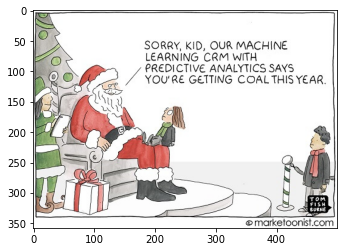

In [524]:
# сюда
import requests
from PIL import Image
import matplotlib.pyplot as plt
from io import BytesIO

%matplotlib inline

url = "https://i0.wp.com/neptune.ai/wp-content/uploads/machine-learning-christmas-cartoon.jpg?resize=500%2C358&ssl=1"
response = requests.get(url)
img_before = np.asarray(Image.open(BytesIO(response.content)))
plt.imshow(img_before);

###### Всех с наступающим